# Importing the Libraries

In [1]:
import optuna
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.linear_model import Ridge, LogisticRegression, LassoCV, Lasso
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix,accuracy_score, recall_score, precision_score, f1_score
from sklearn.feature_selection import SelectFromModel, SelectKBest, chi2, RFE, mutual_info_classif as MIC

# Importing the dataset

In [2]:
dataset = pd.read_csv('bank-additional-full.csv', sep=';', quotechar='"')

In [3]:
dataset_copy = dataset.copy()

In [4]:
dataset.shape

(41188, 21)

#### Reordering the columns order as numerical to categorical

In [5]:
def change_column_type_object_to_categorical(df):
    object_columns = df.select_dtypes(include=['object']).columns.tolist()
    for column in object_columns:
        df[column] = pd.Categorical(df[column])

In [6]:
change_column_type_object_to_categorical(dataset_copy)

In [7]:
# Separate numerical and categorical columns
numerical_columns = dataset_copy.select_dtypes(include='number').columns.tolist()
categorical_columns = dataset_copy.select_dtypes(exclude='number').columns.tolist()

# Reorder the dataset as starting with numerical columns then categorical
new_order = numerical_columns + categorical_columns
dataset_copy = dataset_copy[new_order]

In [8]:
dataset_copy.dtypes

age                  int64
duration             int64
campaign             int64
pdays                int64
previous             int64
emp.var.rate       float64
cons.price.idx     float64
cons.conf.idx      float64
euribor3m          float64
nr.employed        float64
job               category
marital           category
education         category
default           category
housing           category
loan              category
contact           category
month             category
day_of_week       category
poutcome          category
y                 category
dtype: object

## Defining required functions:

In [9]:
def visualize_features(df,column_name):
    plt.figure(figsize=(8, 5))
    sns.histplot(data=df, x=column_name, kde=True, color='skyblue')
    plt.title(f"Distribution of {column_name}")
    plt.xlabel(column_name)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

In [10]:
def visualize_target_feature(df,column_name):
    plt.figure(figsize=(8, 5))
    sns.histplot(data=df, x=column_name, hue='y', multiple='stack', palette='Set2')
    plt.title(f"Distribution of 'y' within {column_name} Groups")
    plt.xlabel(column_name)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

In [11]:
def visualize_outliers(df, column_name):
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=df, x=column_name, color='skyblue')
    plt.title(f"Boxplot of {column_name} (with Outliers)")
    plt.xlabel(column_name)
    plt.tight_layout()
    plt.show()

In [12]:
def visualize(df,column_name):
    visualize_features(df,column_name)
    visualize_target_feature(df,column_name)
    visualize_outliers(df, column_name)

In [13]:
def remove_outliers_by_quantiles(df, column_name, lower_quantile=0.05, upper_quantile=0.95):
    lower_bound = df[column_name].quantile(lower_quantile)
    upper_bound = df[column_name].quantile(upper_quantile)
    df.drop(df[(df[column_name] < lower_bound) | (df[column_name] > upper_bound)].index, inplace=True)

In [14]:
def extract_feature_by_thresholds(df,col_name,thresholds):
    labels = []
    for i in range(len(thresholds) - 1):
        label = f"{col_name}_({thresholds[i]}_{thresholds[i+1]}]"
        mask = (df[col_name] > thresholds[i]) & (df[col_name] <= thresholds[i+1])
        df.loc[mask, f'{col_name}_group'] = label
        labels.append(label)

In [15]:
def print_extract_feature_by_thresholds(df,col_name,thresholds):
    percentages = {}
    total_samples = len(df)
    for i in range(len(thresholds) - 1):
        lower_bound = thresholds[i]
        upper_bound = thresholds[i + 1]
        mask = (df[col_name] > lower_bound) & (df[col_name] <= upper_bound)
        count = df.loc[mask].shape[0]
        percentage = (count / total_samples)
        rounded_percentage = round(percentage, 4)
        print(f"({lower_bound}_{upper_bound}] = {rounded_percentage}, samples:{count}")

In [16]:
def calculate_success_rate(df, feature_column, target_column, lower_bound,upper_bound):
    # Filter the DataFrame for the specific condition
    filtered_df = df[(df[feature_column] >= lower_bound) & (df[feature_column] <= upper_bound)].copy()
    # Group by the feature column and calculate the rate of 'yes' for each unique value
    grouped = filtered_df.groupby(feature_column)[target_column].apply(lambda x: (x == 'yes').mean())
    success_rate = grouped.mean()
    return grouped, success_rate

In [17]:
def generate_start_end_threshold(df, col_name, increment_range):
    start = df[col_name].min() - (df[col_name].min())%increment_range
    end = df[col_name].max() - (df[col_name].max())%increment_range + increment_range
    return start, end

In [18]:
def generate_threshold(df,col_name,increment_range):
    start, end = generate_start_end_threshold(df,col_name,increment_range)
    thresholds = []
    threshold = start
    while threshold <= end:
        thresholds.append(threshold)
        threshold += increment_range
    return thresholds

In [19]:
def correlation_heatmap(df,numerical_col):
    ## taking from https://github.com/bowcai/bank-analysis/blob/main/bank-analysis.ipynb
    fig= plt.figure(figsize=(8,8))

    corr = df[numerical_col].corr()
    mask = np.triu(df[numerical_col].corr())

    axes = fig.add_axes([0, 0, 1, 1])
    sns.heatmap(corr, annot=True, mask=mask, square=True,fmt='.2g',vmin=-1, vmax=1, center= 0, cmap='viridis',
                linecolor='white', cbar_kws= {'orientation': 'vertical'}, ax=axes)

# Data Visualization

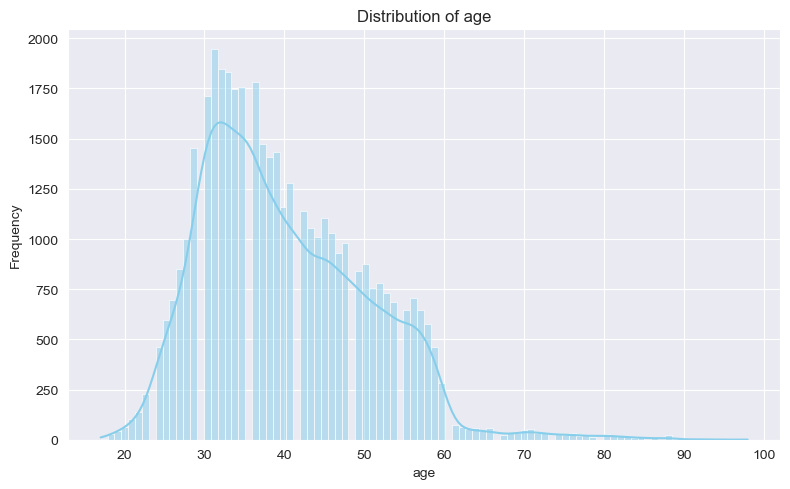

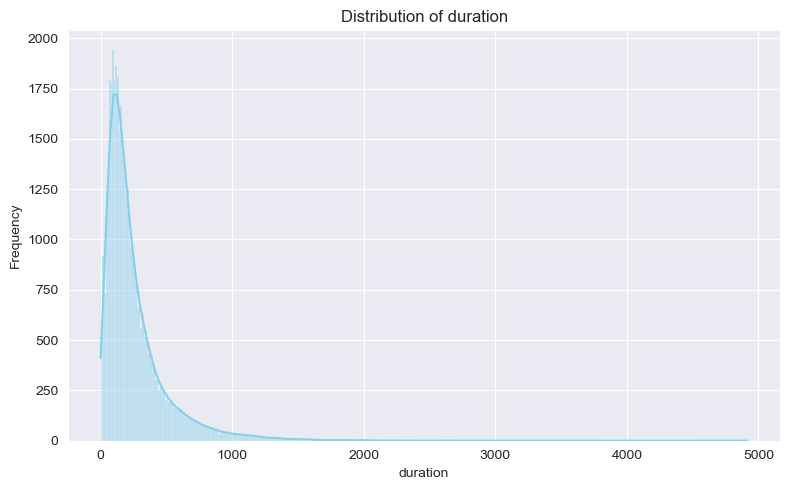

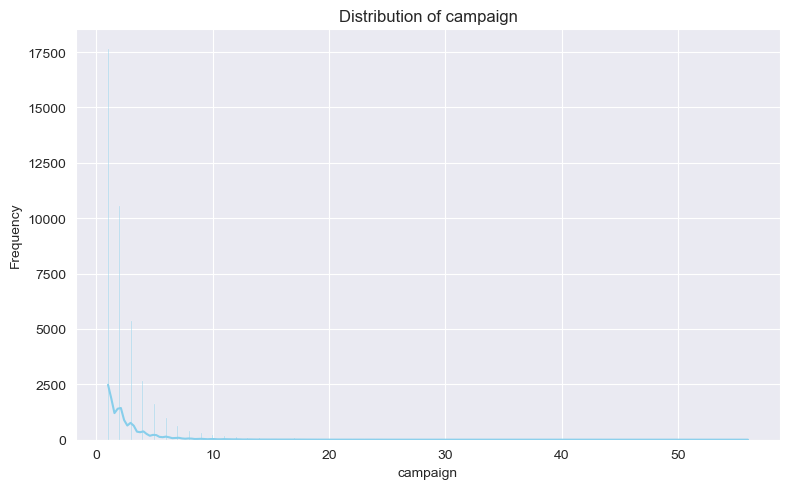

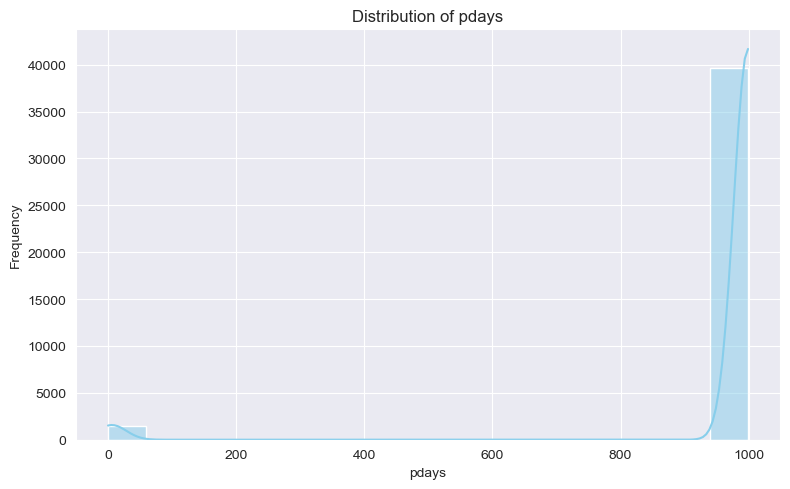

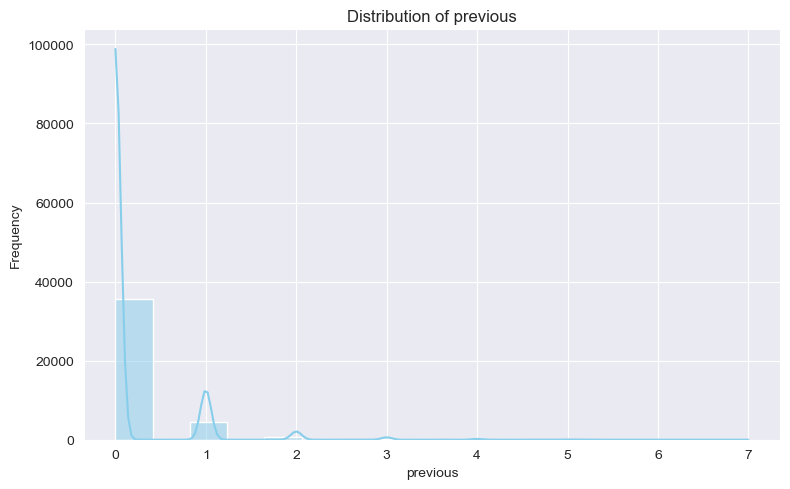

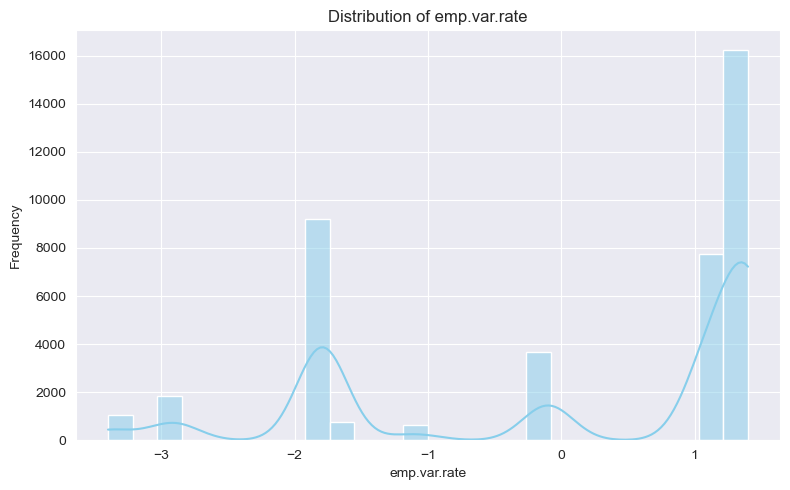

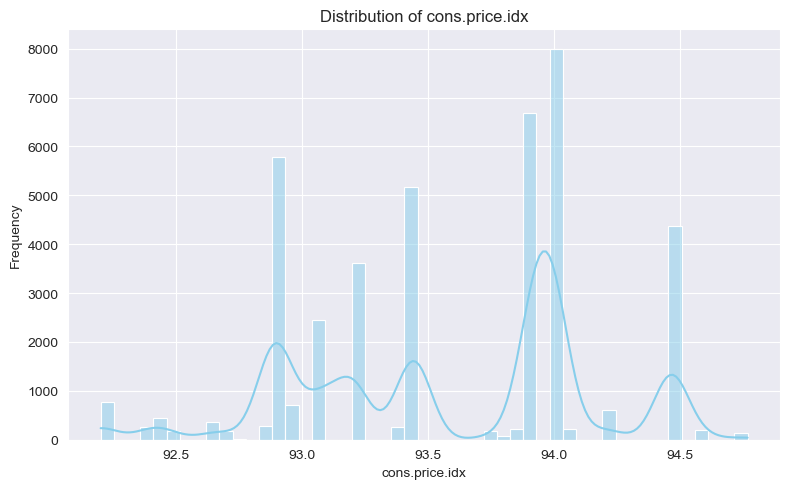

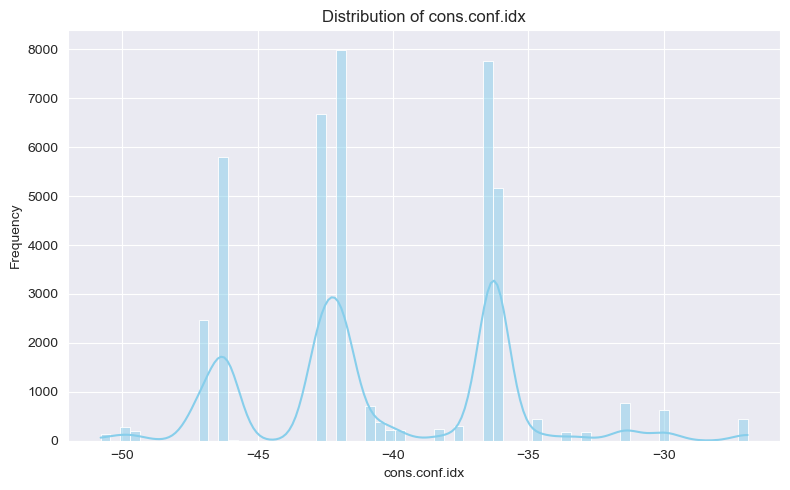

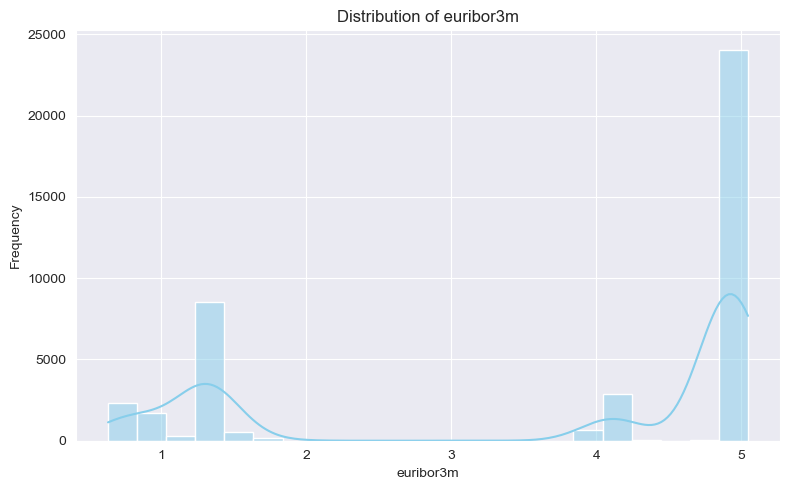

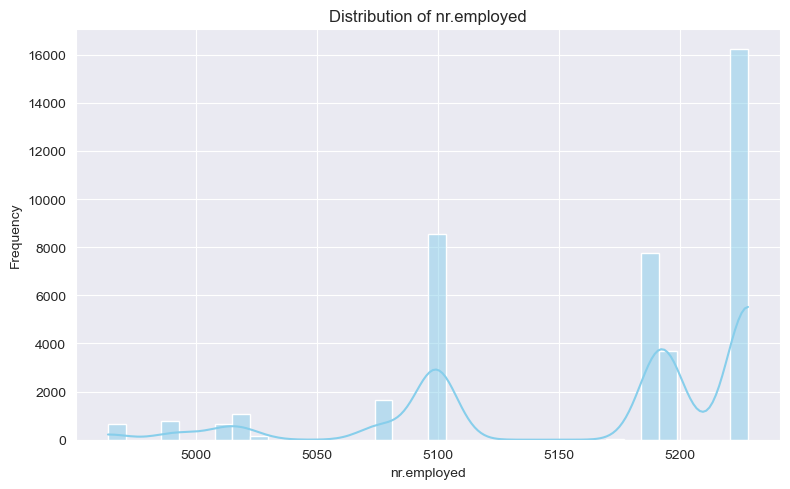

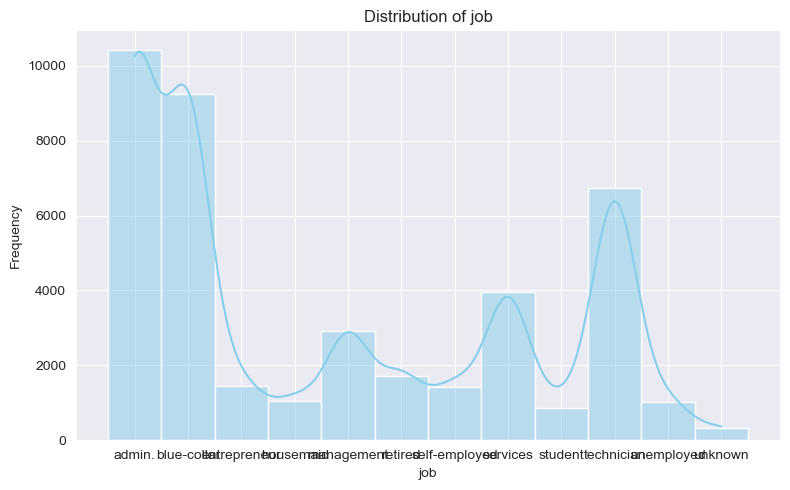

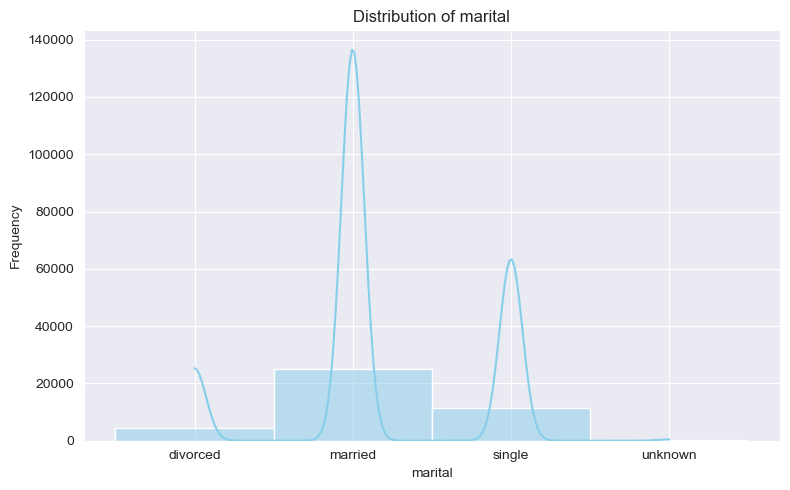

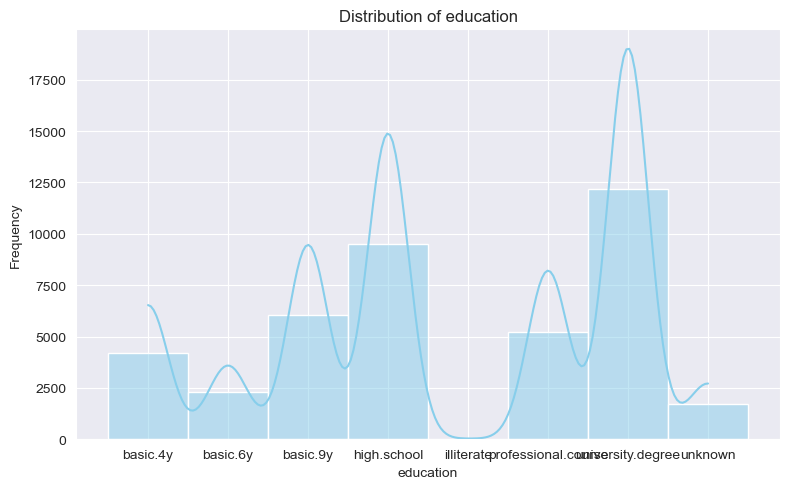

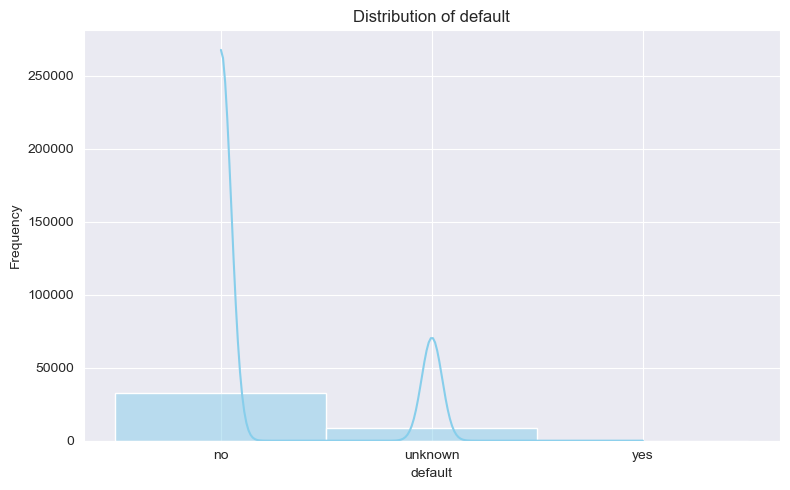

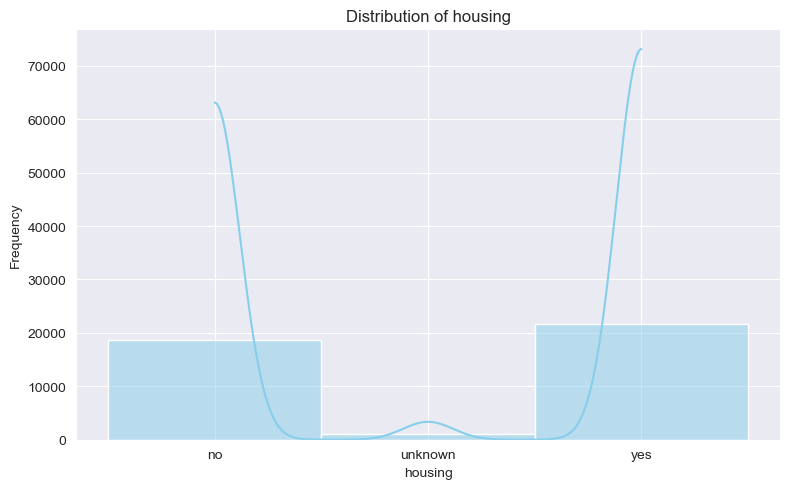

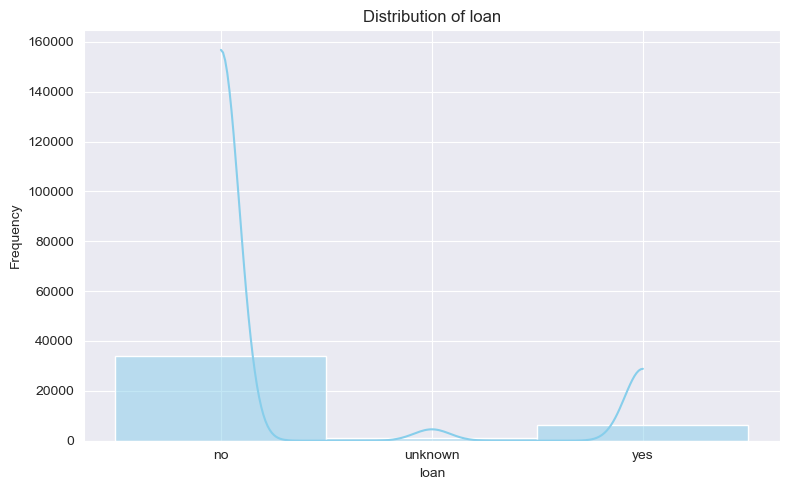

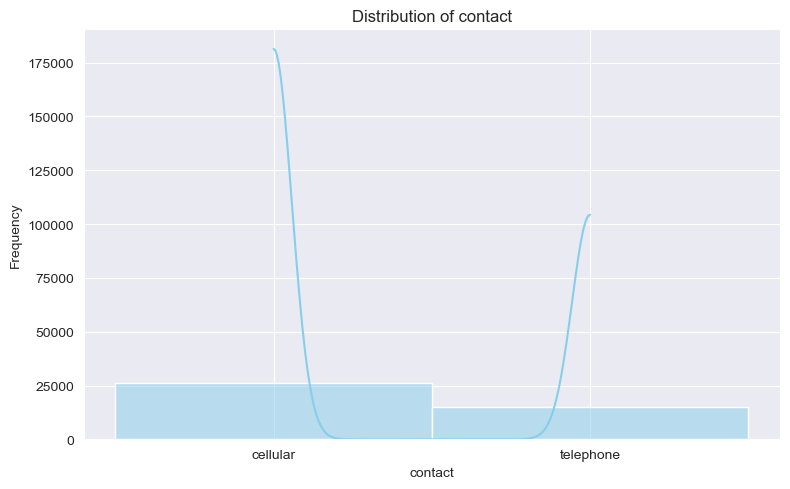

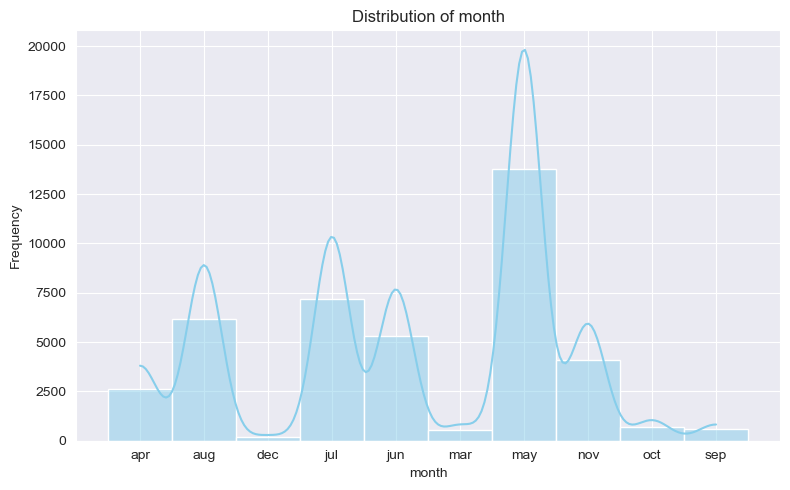

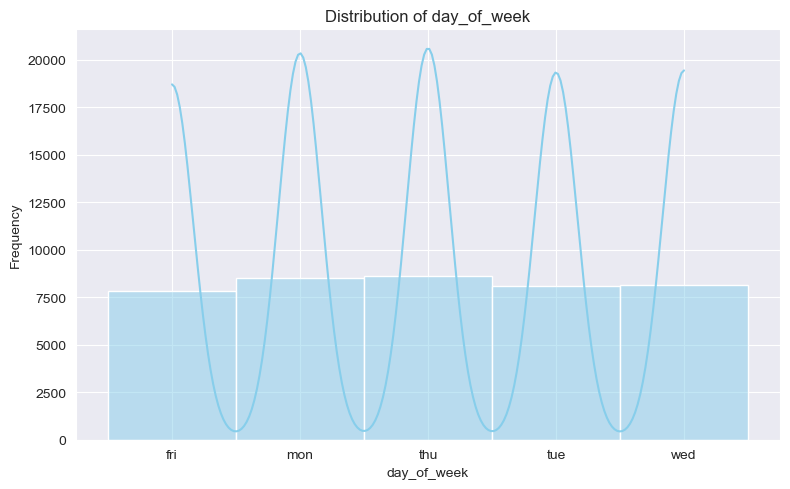

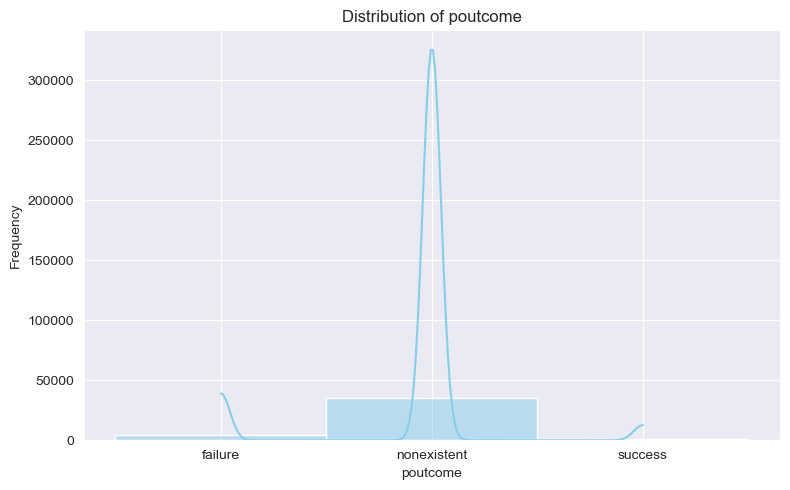

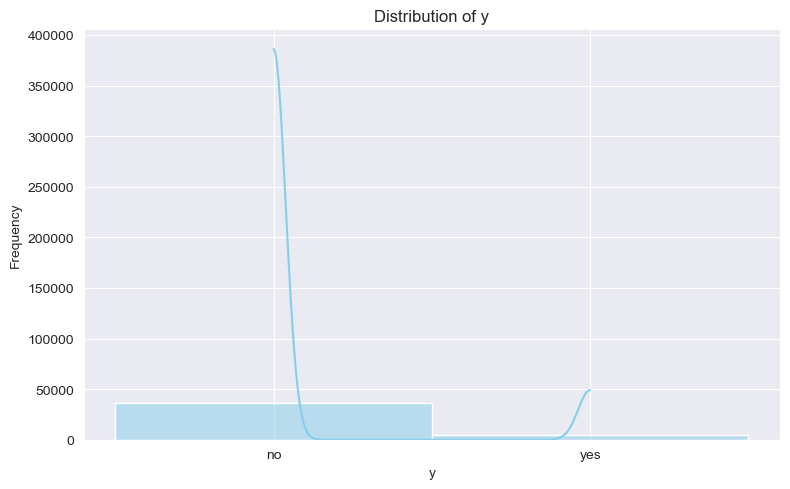

In [20]:
for col in dataset_copy.columns:
    visualize_features(dataset_copy,col)

# Handling outliers

In [21]:
numerical_columns

['age',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'emp.var.rate',
 'cons.price.idx',
 'cons.conf.idx',
 'euribor3m',
 'nr.employed']

In [22]:
for col_name in numerical_columns:
    remove_outliers_by_quantiles(dataset_copy,col_name)

# Handling missing values

In [23]:
# Only categorical features has missing values
print(dataset_copy[categorical_columns].isin(['unknown']).sum())

job             188
marital          46
education       997
default        6314
housing         620
loan            620
contact           0
month             0
day_of_week       0
poutcome          0
y                 0
dtype: int64


In [24]:
# Replacing the "unknown" with np.nan
dataset_copy.replace('unknown', np.nan, inplace=True)
dataset_copy.fillna(dataset_copy.mode().iloc[0], inplace=True)

# Feature Extraction:

##### 1-) "Age"

In [25]:
age_threshold = generate_threshold(dataset_copy,'age',5)
print(age_threshold)

[25, 30, 35, 40, 45, 50, 55, 60]


In [26]:
print_extract_feature_by_thresholds(dataset_copy,'age',age_threshold)

(25_30] = 0.1418, samples:3772
(30_35] = 0.2413, samples:6419
(35_40] = 0.197, samples:5240
(40_45] = 0.1514, samples:4029
(45_50] = 0.1245, samples:3312
(50_55] = 0.0947, samples:2520
(55_60] = 0.0493, samples:1312


In [27]:
extract_feature_by_thresholds(dataset_copy,'age',age_threshold)

##### 2-) "duration"

In [28]:
duration_threshold = generate_threshold(dataset_copy,'duration',100)
print(duration_threshold)

[0, 100, 200, 300, 400, 500, 600, 700, 800]


In [29]:
print_extract_feature_by_thresholds(dataset_copy,'duration',duration_threshold)

(0_100] = 0.2214, samples:5890
(100_200] = 0.3457, samples:9197
(200_300] = 0.1925, samples:5122
(300_400] = 0.1074, samples:2856
(400_500] = 0.0575, samples:1529
(500_600] = 0.0381, samples:1013
(600_700] = 0.0269, samples:716
(700_800] = 0.0106, samples:281


In [30]:
extract_feature_by_thresholds(dataset_copy,'duration',duration_threshold)

##### 3-) "pdays"

In [31]:
dataset_copy['pdays_group'] = dataset_copy['pdays']
dataset_copy.loc[dataset_copy['pdays'] <= 100, 'pdays_group'] = 0
dataset_copy.loc[dataset_copy['pdays'] > 100, 'pdays_group'] = 1

In [32]:
print(dataset_copy['pdays_group'].value_counts())

pdays_group
1    26604
Name: count, dtype: int64


##### 4-) "emp.var.rate"

In [33]:
dataset_copy['emp.var.rate_sign'] = dataset_copy['emp.var.rate']
dataset_copy.loc[dataset_copy['emp.var.rate'] < 0, 'emp.var.rate_sign'] = -1    # negative employment variation rate
dataset_copy.loc[dataset_copy['emp.var.rate'] > 0, 'emp.var.rate_sign'] = 1     # positive employment variation rate

In [34]:
print(dataset_copy['emp.var.rate_sign'].value_counts())

emp.var.rate_sign
 1.0    17789
-1.0     8815
Name: count, dtype: int64


##### 5-) "cons.conf.idx"

In [35]:
cons_conf_idx_threshold = generate_threshold(dataset_copy,'cons.conf.idx',5)
print(cons_conf_idx_threshold)

[-50.0, -45.0, -40.0, -35.0]


In [36]:
print_extract_feature_by_thresholds(dataset_copy,'cons.conf.idx',cons_conf_idx_threshold)

(-50.0_-45.0] = 0.2094, samples:5571
(-45.0_-40.0] = 0.4134, samples:10997
(-40.0_-35.0] = 0.3772, samples:10036


In [37]:
extract_feature_by_thresholds(dataset_copy,'cons.conf.idx',cons_conf_idx_threshold)

# Encoding features:

In [38]:
print(categorical_columns)

['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'y']


In [39]:
label_encoded_features = ['age_group','duration_group','cons.conf.idx_group',
                          'education','default','housing','loan','month',
                          'day_of_week','poutcome','marital','contact','y']
onehot_encoded_features = ['job']

In [40]:
ohe = OneHotEncoder(dtype='int32')
label_encoder = LabelEncoder()

for col in onehot_encoded_features:
    transformed = ohe.fit_transform(dataset_copy[[col]])
    dataset_copy[ohe.categories_[0]] = transformed.toarray()

for column in label_encoded_features:
    dataset_copy[column] = label_encoder.fit_transform(dataset_copy[column])

In [41]:
dataset_copy.dtypes

age                       int64
duration                  int64
campaign                  int64
pdays                     int64
previous                  int64
emp.var.rate            float64
cons.price.idx          float64
cons.conf.idx           float64
euribor3m               float64
nr.employed             float64
job                    category
marital                   int32
education                 int32
default                   int32
housing                   int32
loan                      int32
contact                   int32
month                     int32
day_of_week               int32
poutcome                  int32
y                         int32
age_group                 int32
duration_group            int32
pdays_group               int64
emp.var.rate_sign       float64
cons.conf.idx_group       int32
admin.                    int32
blue-collar               int32
entrepreneur              int32
housemaid                 int32
management                int32
retired 

# Feature Reduction:

<Axes: >

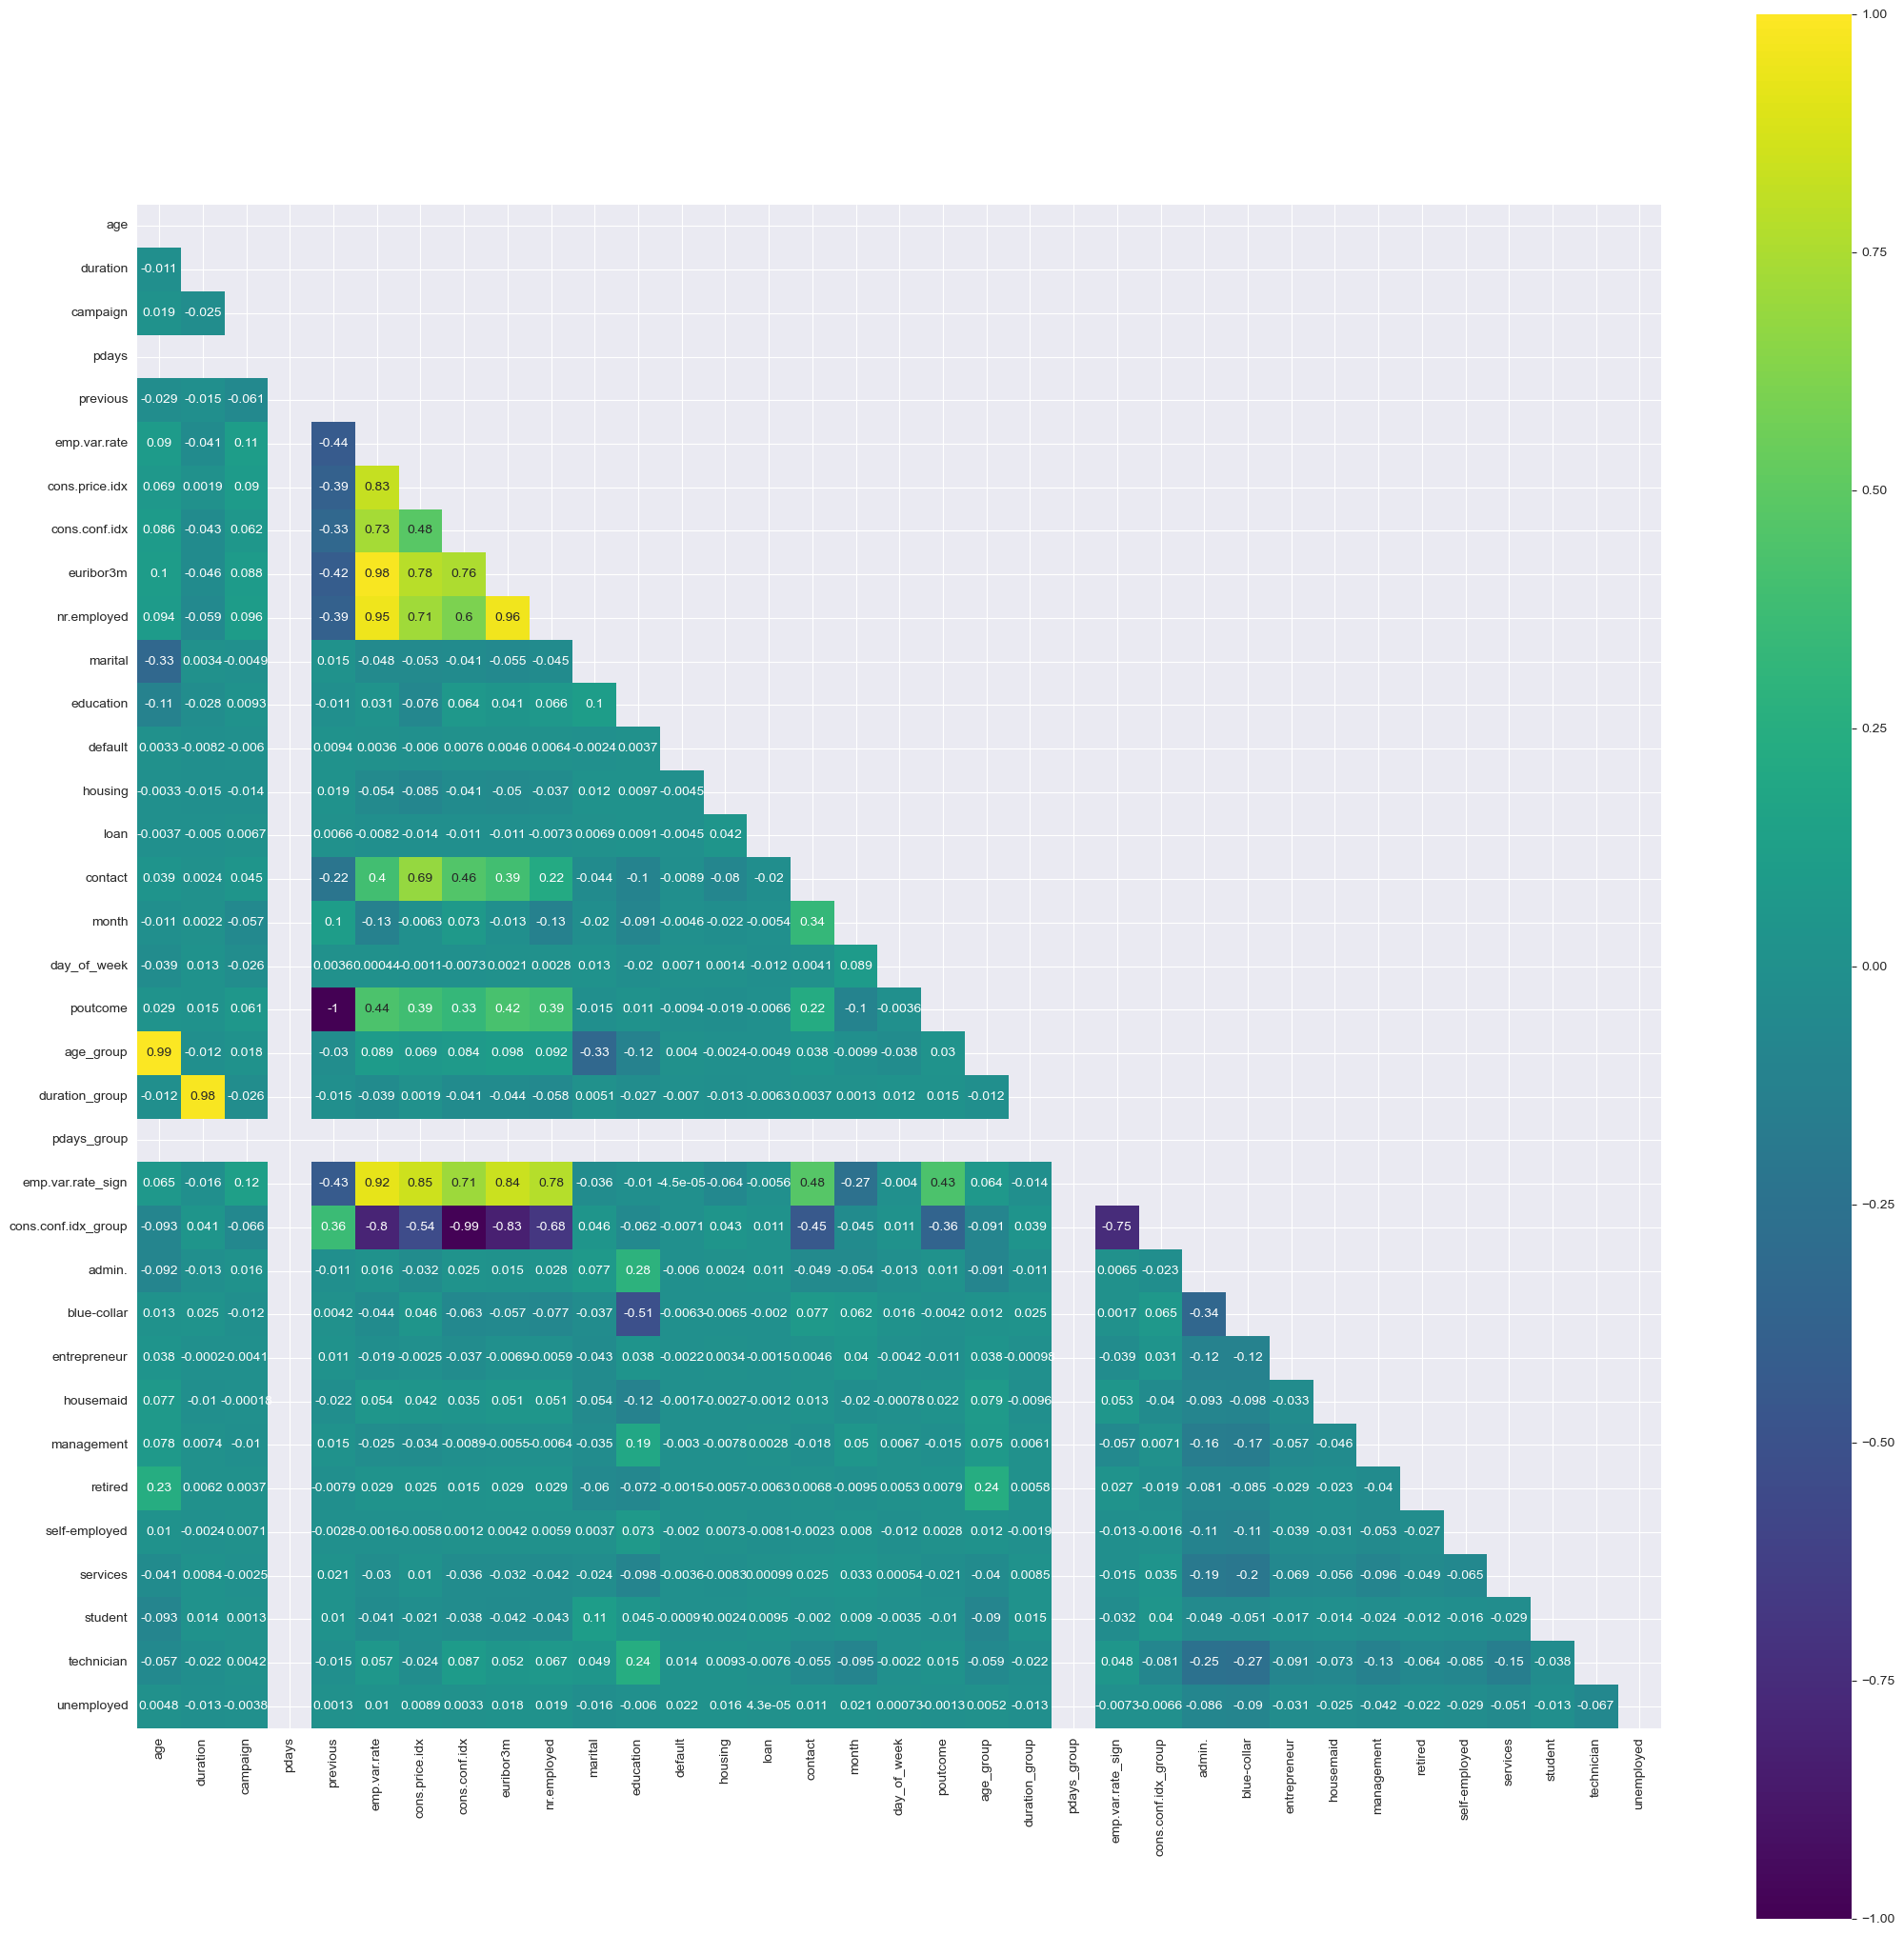

In [42]:
fig= plt.figure(figsize=(20,20))
df = dataset_copy.drop(['y','job'], axis=1)
corr = df.corr()
mask = np.triu(df.corr())

axes = fig.add_axes([0, 0, 1, 1])
sns.heatmap(corr, annot=True, mask=mask, square=True,fmt='.2g',vmin=-1, vmax=1, center= 0, cmap='viridis',
            linecolor='white', cbar_kws= {'orientation': 'vertical'}, ax=axes)

In [43]:
# Remove the one of the high correlated features
dataset_selected= dataset_copy.drop(['age_group','duration','pdays','pdays_group','cons.price.idx','job','poutcome','emp.var.rate','cons.conf.idx', 'euribor3m', 'nr.employed'], axis=1)
numerical_columns = dataset_selected.select_dtypes(include='number').columns.tolist()

<Axes: >

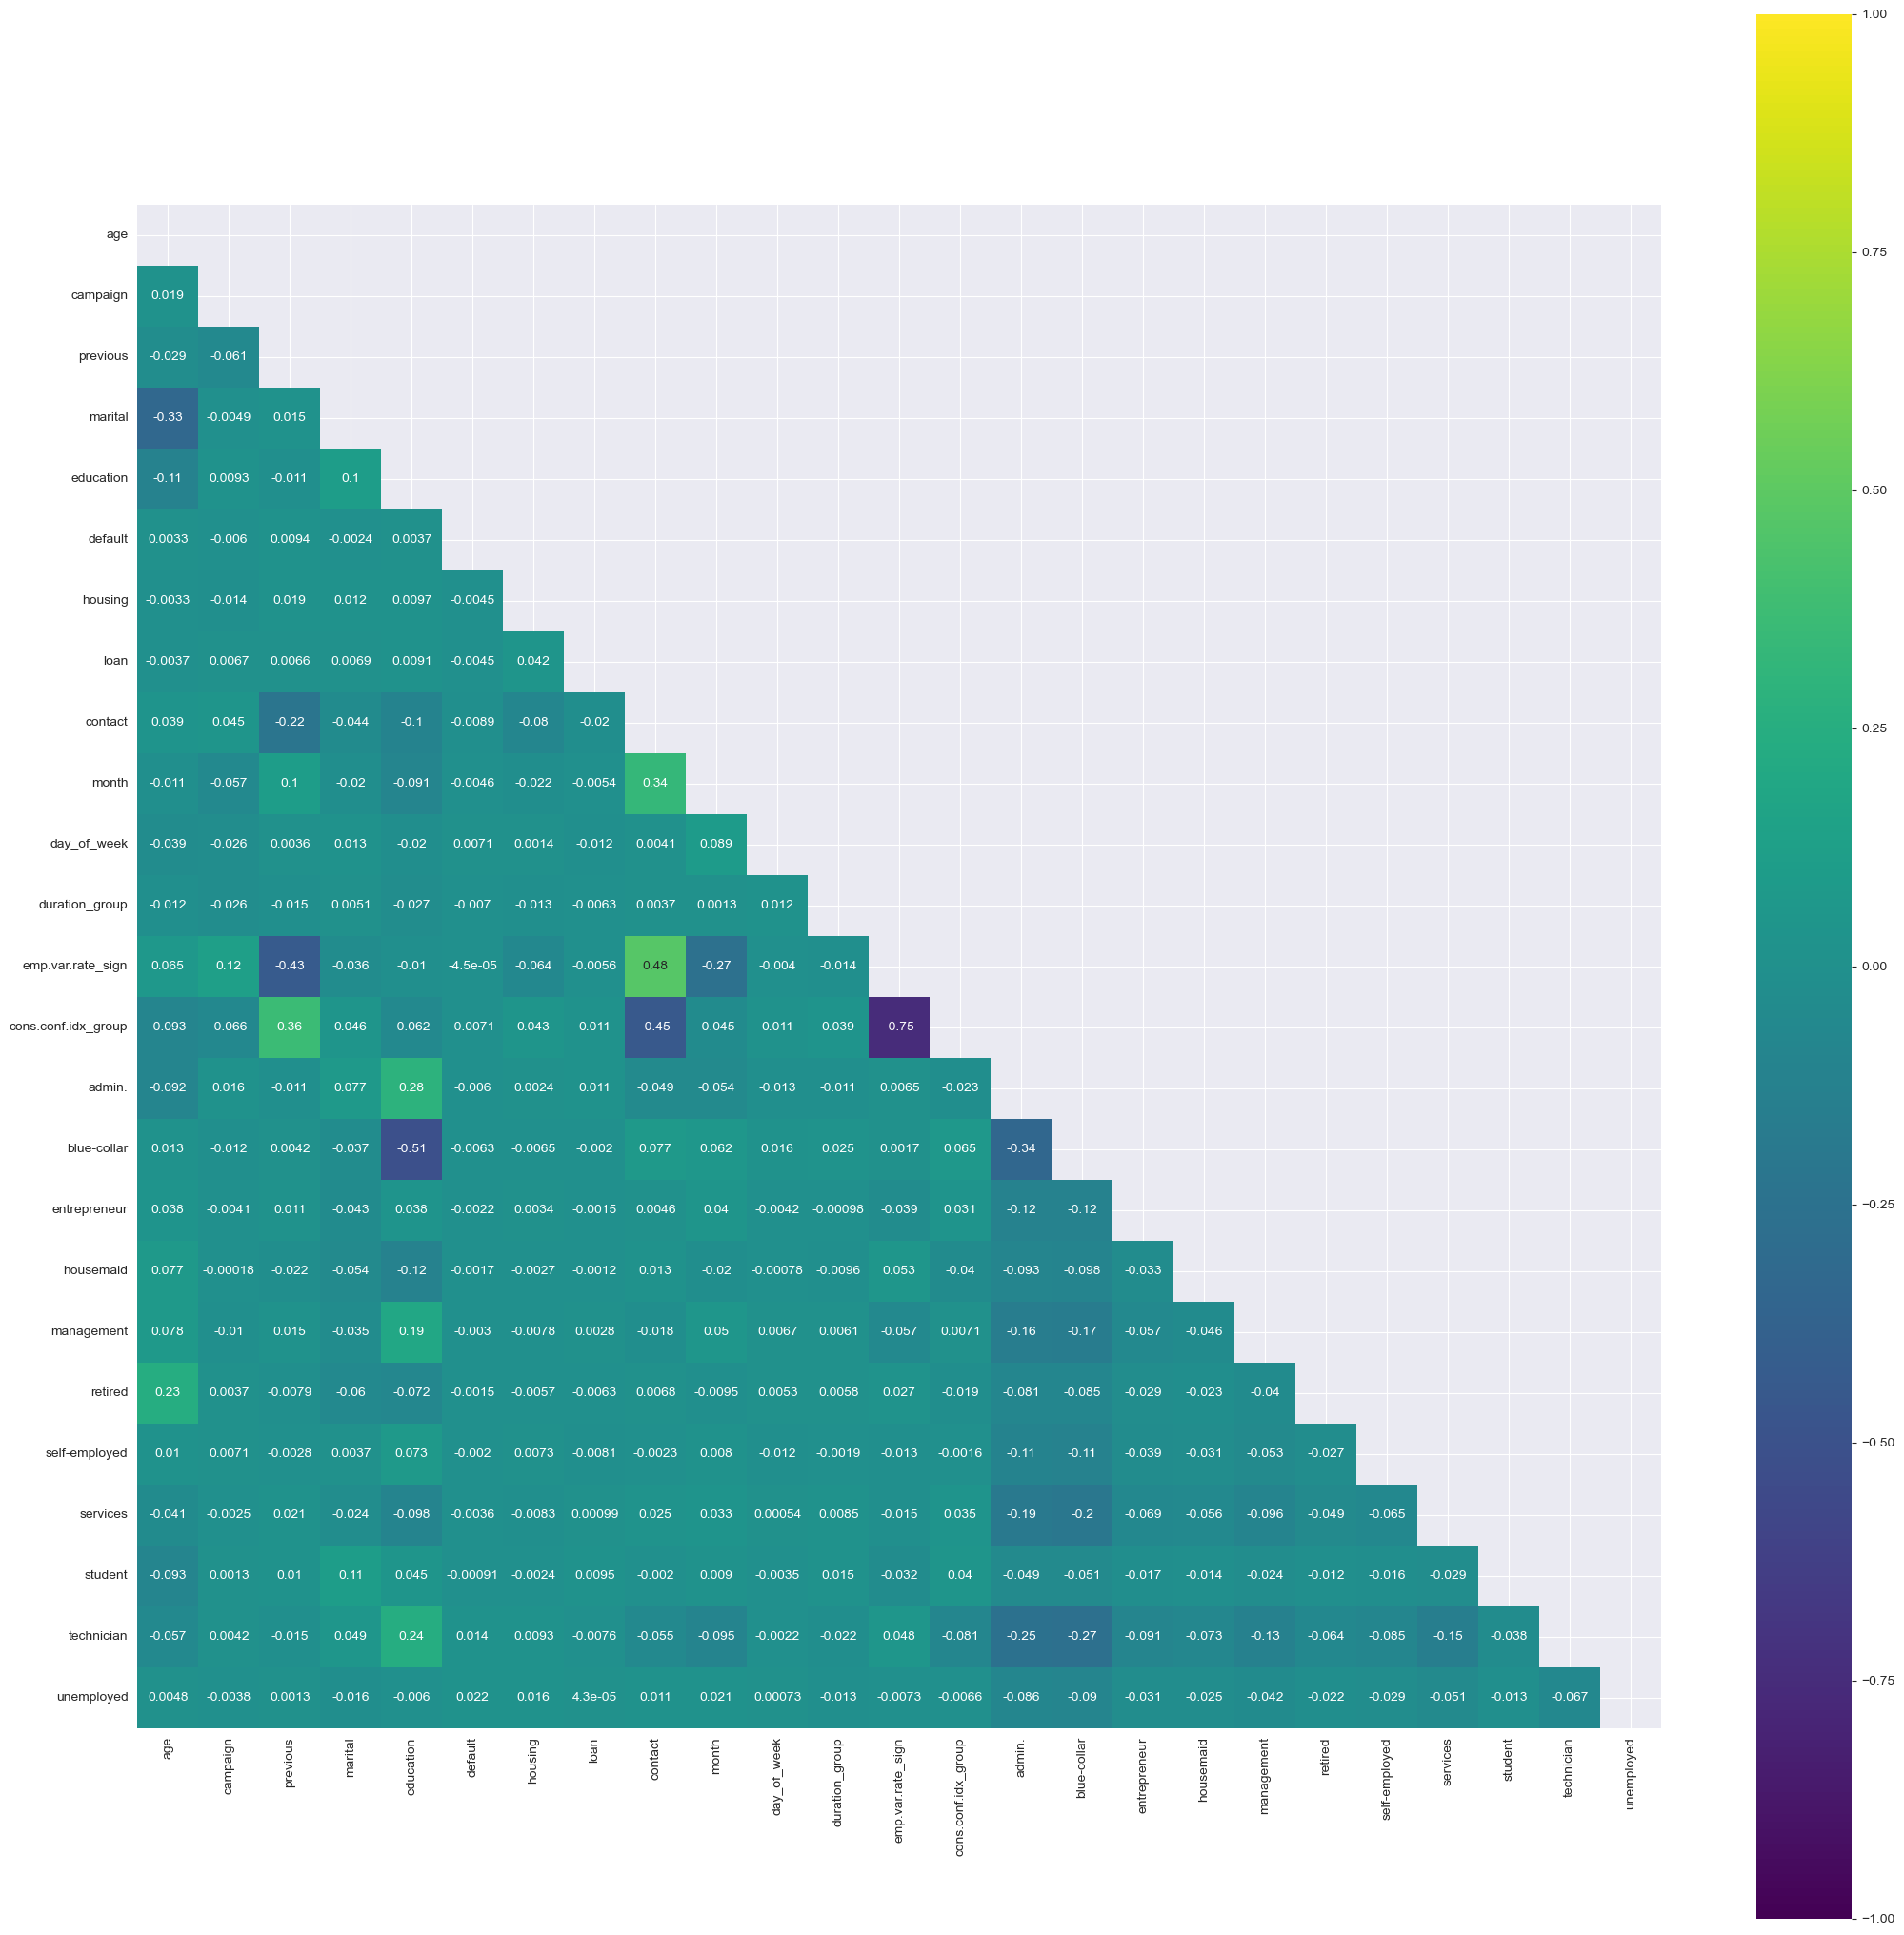

In [44]:
fig= plt.figure(figsize=(20,20))
df = dataset_selected.drop(['y'], axis=1)
corr = df.corr()
mask = np.triu(df.corr())

axes = fig.add_axes([0, 0, 1, 1])
sns.heatmap(corr, annot=True, mask=mask, square=True,fmt='.2g',vmin=-1, vmax=1, center= 0, cmap='viridis',
            linecolor='white', cbar_kws= {'orientation': 'vertical'}, ax=axes)

In [45]:
dataset_selected.columns

Index(['age', 'campaign', 'previous', 'marital', 'education', 'default',
       'housing', 'loan', 'contact', 'month', 'day_of_week', 'y',
       'duration_group', 'emp.var.rate_sign', 'cons.conf.idx_group', 'admin.',
       'blue-collar', 'entrepreneur', 'housemaid', 'management', 'retired',
       'self-employed', 'services', 'student', 'technician', 'unemployed'],
      dtype='object')

In [46]:
dataset_selected.dtypes

age                      int64
campaign                 int64
previous                 int64
marital                  int32
education                int32
default                  int32
housing                  int32
loan                     int32
contact                  int32
month                    int32
day_of_week              int32
y                        int32
duration_group           int32
emp.var.rate_sign      float64
cons.conf.idx_group      int32
admin.                   int32
blue-collar              int32
entrepreneur             int32
housemaid                int32
management               int32
retired                  int32
self-employed            int32
services                 int32
student                  int32
technician               int32
unemployed               int32
dtype: object

# Feature Sampling:

In [47]:
dataset_copy.shape

(26604, 37)

In [48]:
X = dataset_selected.drop(['y'], axis=1)
y = dataset_selected['y']

In [49]:
from imblearn.over_sampling import RandomOverSampler

counter = Counter(y)
print(f"Before oversampling:{counter}")

oversampling = RandomOverSampler()
X_oversampled, y_oversampled = oversampling.fit_resample(X, y)

counter = Counter(y_oversampled)
print(f"After oversampling:{counter}")

Before oversampling:Counter({0: 25653, 1: 951})
After oversampling:Counter({0: 25653, 1: 25653})


# Feature Transformation

In [50]:
# Apply Min_Max scaler
scaler_minmax = MinMaxScaler()
scaler_standard = StandardScaler()

X_minmax = scaler_minmax.fit_transform(X_oversampled)
X_standard = scaler_standard.fit_transform(X_oversampled)

# Feature Selection:

In [51]:
# Prepare dataset for RFE (Recursive Feature Elimination)
def func_RFE_X_rfe(param_X,param_y):
    model = LogisticRegression(max_iter=1000)
    rfe = RFE(model, step = 4)
    fit = rfe.fit(param_X,param_y)
    selected_features = fit.support_
    X_rfe = param_X[:, selected_features]
    return X_rfe

In [52]:
# Prepare dataset for SelectKBest (score_func=chi2)
def func_SelectKBest_X_chi2(param_X,param_y):
    test = SelectKBest(score_func=chi2, k=23)
    fit = test.fit(param_X,param_y)
    X_chi2 = fit.transform(param_X)
    return X_chi2

In [53]:
# Prepare dataset for Ridge
def func_Ridge_X_ridge(param_X,param_y):
    ridge = Ridge(alpha=1.0)
    ridge.fit(param_X,param_y)
    best_alpha = ridge.alpha
    ridge_model = Ridge(alpha=best_alpha)
    ridge_model.fit(param_X,param_y)
    selector = SelectFromModel(ridge_model)
    X_ridge = selector.transform(param_X)
    return X_ridge

In [54]:
# Prepare dataset for MIC (mutual_info_classification)
def func_MIC_X_mic(param_X,param_y):
    mi_scores = MIC(param_X,param_y)
    mi_score_selected_index = np.where(mi_scores <0.2)[0]
    X_mic = param_X[:,mi_score_selected_index]
    return X_mic

In [55]:
def func_Lasso_X(param_X, param_y):
    lasso = LassoCV(cv=10)
    lasso.fit(param_X, param_y)
    best_alpha = lasso.alpha_

    selector = SelectFromModel(Lasso(alpha=best_alpha), threshold='median')
    X_lasso = selector.fit_transform(param_X, param_y)

    return X_lasso

In [56]:
def print_scores(accuracy_score, recall_score, precision_score, f1_score, model_name):
    print(f"accuracy_{model_name}:{accuracy_score:10.4f}\t"
          f"recall {model_name}:{recall_score:10.4f}\t"
          f"precision {model_name}:{precision_score:10.4f}\t"
          f"f1_score_{model_name}:{f1_score:10.4f}")

In [57]:
def predict_scores(model, x_test, y_test):
    y_predict       = model.predict(x_test)
    score_accuracy  = accuracy_score(y_test, y_predict)
    score_recall    = recall_score(y_test,y_predict)
    score_precision = precision_score(y_test,y_predict)
    f1_scr          = f1_score(y_test, y_predict)
    return score_accuracy,score_recall,score_precision, f1_scr

In [58]:
def func_Calculate_Model_Scores(param_x,param_y, X_chi2, X_rfe, X_ridge, X_mic, X_lasso):
    # Split the data into training and testing sets
    
    X_train, X_test, y_train, y_test                     = train_test_split(param_x,param_y, random_state=0, stratify=param_y)
    X_train_chi2, X_test_chi2, y_train_chi2, y_test_chi2 = train_test_split(X_chi2, param_y, random_state=0, stratify=param_y)
    X_train_RFE, X_test_RFE, y_train_RFE, y_test_RFE     = train_test_split(X_rfe, param_y, random_state=0, stratify=param_y)
    X_train_Ridge, X_test_Ridge, y_train_Ridge, y_test_Ridge = train_test_split(X_ridge, param_y, random_state=0, stratify=param_y)
    X_train_MIC, X_test_MIC, y_train_MIC, y_test_MIC     = train_test_split(X_mic, param_y, random_state=0, stratify=param_y)
    X_train_Lasso, X_test_Lasso, y_train_Lasso, y_test_Lasso = train_test_split(X_lasso, param_y, random_state=0, stratify=param_y)
    RFC = RandomForestClassifier()

    # Compare results with Random Forest Classifier
    model_default = RFC.fit(X_train,y_train)
    score_default, recall_score_default, precision_score_default, f1_score_default = predict_scores(model_default,X_test,y_test) 

    model_MIC = RFC.fit(X_train_MIC,y_train_MIC)
    score_MIC, recall_score_MIC, precision_score_MIC, f1_score_MIC = predict_scores(model_MIC,X_test_MIC,y_test_MIC)

    model_chi2 = RFC.fit(X_train_chi2,y_train_chi2)
    score_chi2, recall_score_chi2, precision_score_chi2, f1_score_chi2 = predict_scores(model_chi2,X_test_chi2,y_test_chi2)

    model_RFE = RFC.fit(X_train_RFE,y_train_RFE)
    score_rfe, recall_score_rfe, precision_score_rfe, f1_score_rfe = predict_scores(model_RFE,X_test_RFE,y_test_RFE)

    model_Ridge = RFC.fit(X_train_Ridge,y_train_Ridge)
    score_ridge, recall_score_ridge, precision_score_ridge, f1_score_ridge = predict_scores(model_Ridge,X_test_Ridge,y_test_Ridge)

    model_Lasso = RFC.fit(X_train_Lasso,y_train_Lasso)
    score_lasso, recall_score_lasso, precision_score_lasso, f1_score_lasso = predict_scores(model_Lasso,X_test_Lasso,y_test_Lasso)
    
    #---------------------------------------------------------------------------------
    model_names = ['Default','CHI2','RFE','Ridge','MIC','Lasso']
    scores = [score_default ,score_chi2 ,score_rfe ,score_ridge ,score_MIC ,score_lasso]
    recalls = [recall_score_default ,recall_score_chi2 ,recall_score_rfe ,recall_score_ridge ,recall_score_MIC ,recall_score_lasso]
    precisions = [precision_score_default,precision_score_chi2,precision_score_rfe,precision_score_ridge,precision_score_MIC,precision_score_lasso]
    f1_scores = [f1_score_default,f1_score_chi2,f1_score_rfe,f1_score_ridge,f1_score_MIC,f1_score_lasso]

    scores_df = pd.DataFrame({
        "Model": model_names,
        "Score": scores,
        "Recall": recalls,
        "Precision": precisions,
        "F1 Score": f1_scores
    })
    
    return  scores_df

In [59]:
print("Scores for minmax scaler:")
x_chi2 = func_SelectKBest_X_chi2(X_minmax,y_oversampled)
x_rfe = func_RFE_X_rfe(X_minmax,y_oversampled)
x_ridge = func_Ridge_X_ridge(X_minmax,y_oversampled)
x_mic = func_MIC_X_mic(X_minmax,y_oversampled)
x_lasso = func_Lasso_X(X_minmax,y_oversampled)

df_featureSelection  = func_Calculate_Model_Scores(X_minmax, y_oversampled, x_chi2, x_rfe, x_ridge, x_mic, x_lasso)

Scores for minmax scaler:


In [60]:
df_featureSelection

,Model,Score,Recall,Precision,F1 Score
0,Default,0.992282,1.000000,0.984797,0.992340
1,CHI2,0.992672,1.000000,0.985554,0.992724
2,RFE,0.982615,1.000000,0.966395,0.982911
3,Ridge,0.873626,0.899891,0.854963,0.876852
4,MIC,0.990957,1.000000,0.982233,0.991037
5,Lasso,0.992672,1.000000,0.985554,0.992724


# Cross Validation for feature selection 

In [61]:
def find_best_rfe_params(param_X, param_y):
    model = LogisticRegression()
    rfe = RFE(model)

    param_grid = {
        'estimator__max_iter': [100, 500, 1000, 2000],
        'step': [1, 2, 4, 8]
    }
    grid_search = GridSearchCV(rfe, param_grid, cv=5)
    grid_search.fit(param_X, param_y)

    best_max_iter = grid_search.best_params_['estimator__max_iter']
    best_step = grid_search.best_params_['step']

    print("Best max_iter Parameter:", best_max_iter)
    print("Best Step Parameter:", best_step)

    best_rfe_model = RFE(LogisticRegression(max_iter=best_max_iter), step=best_step)
    best_rfe_model.fit(param_X, param_y)

    print("Num Features: %s" % (best_rfe_model.n_features_))
    print("Selected Features: %s" % (best_rfe_model.support_))
    print("Feature Ranking: %s" % (best_rfe_model.ranking_))
    X_rfe = best_rfe_model.fit_transform(param_X, param_y)
    return X_rfe

In [62]:
from sklearn.pipeline import Pipeline
def find_best_chi2_params(param_X, param_y):
    k_values = list(range(10, 26))

    param_grid = {'kbest__k': k_values} 
    classifier = RandomForestClassifier()
    select_k_best = SelectKBest(score_func=chi2)
    pipeline = Pipeline([('kbest', select_k_best), ('classifier', classifier)])
    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5)
    grid_search.fit(param_X, param_y)
    best_k = grid_search.best_params_['kbest__k']
    select_k_best = SelectKBest(score_func=chi2, k=best_k)
    X_chi2 = select_k_best.fit_transform(param_X, param_y)

    print(f"The best value for k is {best_k}.")

    return X_chi2

In [63]:
def find_best_ridge_params(param_X,param_y):
   
    alpha_values = [0.1, 0.2, 0.4, 0.6, 0.8, 1.0]
    param_grid = {'alpha': alpha_values}

    ridge = Ridge()
    grid_search = GridSearchCV(estimator=ridge, param_grid=param_grid, cv=5)
    grid_search.fit(param_X,param_y)

    best_alpha = grid_search.best_params_['alpha']
    print(f"The best value for alpha is {best_alpha}.")
    
    ridge_model = Ridge(alpha=best_alpha)
    ridge_model.fit(param_X,param_y)
    selector = SelectFromModel(ridge_model)
    X_ridge = selector.transform(param_X)

    return X_ridge

In [64]:
x_chi2 = find_best_chi2_params(X_minmax,y_oversampled)
x_rfe = find_best_ridge_params(X_minmax,y_oversampled)
x_ridge = func_Ridge_X_ridge(X_minmax,y_oversampled)
x_mic = func_MIC_X_mic(X_minmax,y_oversampled)
x_lasso = func_Lasso_X(X_minmax,y_oversampled)

df_featureSelection  = func_Calculate_Model_Scores(X_minmax, y_oversampled, x_chi2, x_rfe, x_ridge, x_mic, x_lasso)

The best value for k is 24.
The best value for alpha is 0.1.


In [65]:
df_featureSelection

,Model,Score,Recall,Precision,F1 Score
0,Default,0.992828,1.000000,0.985857,0.992878
1,CHI2,0.992984,1.000000,0.986160,0.993032
2,RFE,0.873626,0.899891,0.854963,0.876852
3,Ridge,0.873626,0.899891,0.854963,0.876852
4,MIC,0.991035,1.000000,0.982384,0.991114
5,Lasso,0.992594,1.000000,0.985403,0.992648


## Implementing Elbow 

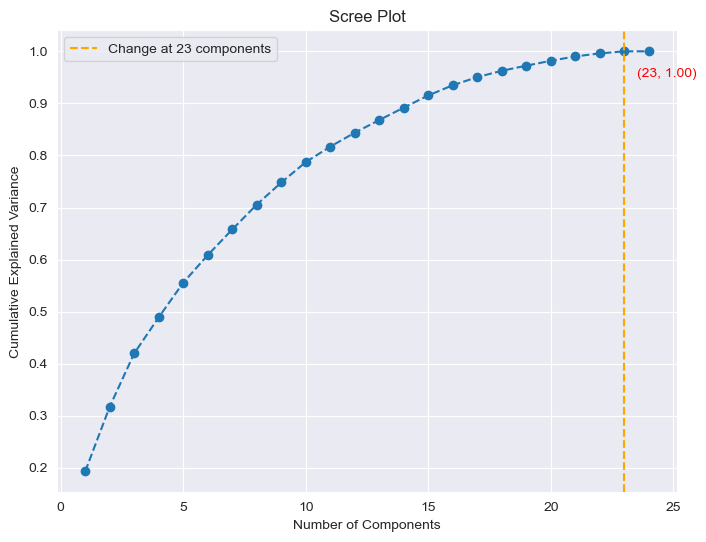

In [66]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


pca = PCA()
pca.fit(x_chi2)

explained_var = pca.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_var) + 1), cumulative_var, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot')

# Calculate the rate of change in explained variance
diff = np.diff(cumulative_var)
change_point = np.where(diff == np.min(diff))[0][0] + 1

plt.axvline(x=change_point, color='orange', linestyle='--', label=f'Change at {change_point} components')
plt.text(change_point + 0.5, cumulative_var[change_point - 1] - 0.05, f'({change_point}, {cumulative_var[change_point - 1]:.2f})', color='red')

plt.legend()
plt.grid(True)
plt.show()

In [67]:
from sklearn.decomposition import PCA

pca = PCA(n_components=change_point) 
X_pca = pca.fit_transform(x_chi2)

X_train, X_test, y_train, y_test = train_test_split(X_pca, y_oversampled, test_size=0.2, random_state=42)

model_rfc_pca = RandomForestClassifier()
model_rfc_pca.fit(X_train, y_train)

# Make predictions
y_pred = model_rfc_pca.predict(X_test)

score_default, recall_score_default, precision_score_default, f1_score_default = predict_scores(model_rfc_pca,X_test,y_test)

print("Scores for PCA with RandomForest:")
print("Accuracy: {:.4f}".format(score_default))
print("Recall: {:.4f}".format(recall_score_default))
print("Precision: {:.4f}".format(precision_score_default))
print("F1 Score: {:.4f}".format(f1_score_default))

Scores for PCA with RandomForest:
Accuracy: 0.9953
Recall: 1.0000
Precision: 0.9907
F1 Score: 0.9953


# Splitting the dataset into the Training set and Test set

In [68]:
X_train, X_test, y_train, y_test   = train_test_split(X_pca,y_oversampled, random_state=42)

# Feature Scaling

In [69]:
sc = StandardScaler()
X_train_ml = sc.fit_transform(X_train)
X_test_ml = sc.transform(X_test)

# ML Algorithms Implementation:

In [70]:
def plot_confusion_matrix(X_test, y_test, model, model_name):
    # Generate confusion matrix
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    # Create a custom colormap for better readability
    cmap = sns.diverging_palette(250, 10, as_cmap=True)

    # Create a heatmap with customized colors and annotations
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, cmap=cmap, fmt='g', cbar=False)

    # Set labels, title, and layout
    plt.title(f'Confusion Matrix of {model_name}', fontsize=16)
    plt.xlabel('Predicted', fontsize=8)
    plt.ylabel('Actual', fontsize=8)
    plt.xticks(ticks=[0.5, 1.5], labels=['Negative', 'Positive'])
    plt.yticks(ticks=[0.5, 1.5], labels=['Negative', 'Positive'])
    plt.tight_layout()

    plt.show()

In [71]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

def draw_AUC_graph(train_X, test_X, train_y, test_y, model, model_name):
    # Get predicted probabilities for the positive class for both train and test sets
    y_train_probs = model.predict_proba(train_X)[:, 1]
    y_test_probs = model.predict_proba(test_X)[:, 1]

    # Compute ROC curve and ROC AUC for both train and test sets
    fpr_train, tpr_train, _ = roc_curve(train_y, y_train_probs)
    fpr_test, tpr_test, _ = roc_curve(test_y, y_test_probs)

    roc_auc_train = roc_auc_score(train_y, y_train_probs)
    roc_auc_test = roc_auc_score(test_y, y_test_probs)

    # Plot ROC curves for both train and test sets, display AUC values as labels
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_train, tpr_train, label=f'Train ROC Curve (AUC = {roc_auc_train:.2f})')
    plt.plot(fpr_test, tpr_test, label=f'Test ROC Curve (AUC = {roc_auc_test:.2f})')
    plt.plot([0, 1], [0, 1], 'r--', label='Random Guessing')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve for {model_name}')
    plt.legend()
    plt.show()

    print(f"Train AUC: {roc_auc_train:.4f}")
    print(f"Test AUC: {roc_auc_test:.4f}")

In [72]:
def visualize_fitting_scores(model ,model_name ,X_train, y_train):
    train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=5)
    
    # Calculate the mean for training and test scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    # Calculate the bias and variance
    bias = 1 - train_mean
    variance = test_mean - train_mean
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot Bias-Variance Tradeoff
    ax1.plot(train_sizes, bias, 'o-', color="blue", label="Bias")
    ax1.plot(train_sizes, variance, 'o-', color="orange", label="Variance")
    ax1.set_xlabel("Training examples")
    ax1.set_ylabel("Error")
    ax1.set_title(f"Bias-Variance Tradeoff for {model_name}")
    ax1.legend(loc="best")
    ax1.grid()
    
    # Plot Learning Curve
    ax2.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="b")
    ax2.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="r")
    ax2.plot(train_sizes, train_mean, 'o-', color="blue", label="Training score")
    ax2.plot(train_sizes, test_mean, 'o-', color="red", label="Cross-validation score")
    
    # Calculate test score separately
    test_sizes = np.array([(i + 1) * len(X_train) // 10 for i in range(10)])
    best_model_rfc.fit(X_train, y_train)
    test_score = [best_model_rfc.score(X_test[:size], y_test[:size]) for size in test_sizes]
    ax2.plot(test_sizes, test_score, 'o-', color="orange", label="Test score")
    
    ax2.set_xlabel("Training examples")
    ax2.set_ylabel("Score")
    ax2.set_title(f"Learning Curve with Training, Cross-validation, and Test Scores for {model_name}")
    ax2.legend(loc="best")
    ax2.grid()
    
    plt.tight_layout()
    plt.show()

In [73]:
def ml_algorithms(X_train,y_train):

    # Initialize individual classifiers
    dtc = DecisionTreeClassifier()
    knn = KNeighborsClassifier()
    logistic = LogisticRegression(max_iter=1000)
    rfc = RandomForestClassifier()
    gb = GradientBoostingClassifier()

    # Fit individual classifiers
    dtc.fit(X_train, y_train)
    knn.fit(X_train, y_train)
    logistic.fit(X_train, y_train)
    rfc.fit(X_train, y_train)
    gb.fit(X_train, y_train)
    
    return dtc, knn, logistic, rfc, gb

In [85]:
def ensemble_models(X_train,y_train,estimators):
    
    xgboost = xgb.XGBClassifier()
    voting = VotingClassifier(estimators=estimators, voting='soft')
    stacking = StackingClassifier(estimators=estimators)

    xgboost.fit(X_train,y_train)
    voting.fit(X_train,y_train)
    stacking.fit(X_train,y_train)
    
    return  xgboost, voting, stacking

# Training the Classification models on the Training set

## ML Models

In [75]:
model_dtc, model_knn, model_lr, model_rfc, model_gb= ml_algorithms(X_train=X_train,y_train=y_train)

## Ensemble Models

In [86]:
estimators = [('dtc',model_dtc),('knn',model_knn),('logistic',model_lr),('rfc',model_rfc),('gb', model_gb)]
model_xgb, model_voting, model_stacking = ensemble_models(X_train=X_train,y_train=y_train,estimators=estimators)

# Hyper tuning of ML and ensemble models

## RFC

In [77]:
param_grid = {
    'n_estimators': [50, 100],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [1,5],
    'random_state': [0,42]
}

# Create GridSearchCV
grid_search = GridSearchCV(estimator=model_rfc, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, error_score='raise')

# Perform grid search on training data
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(best_params)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
{'max_features': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50, 'random_state': 0}


In [78]:
best_model_rfc = RandomForestClassifier(**best_params)
best_model_rfc.fit(X_train, y_train)

RandomForestClassifier(max_features=1, n_estimators=50, random_state=0)

## XGB

In [79]:
def objective(trial):
    param_grid = {
        'objective': 'binary:logistic',
        'eval_metric': 'error',
        'booster': 'gbtree',
        'verbosity': 0,
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0.0, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10)
    }

    xgb_model = xgb.XGBClassifier(**param_grid)
    xgb_model.fit(X_train, y_train)

    predictions = xgb_model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    return 1.0 - accuracy 

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='minimize')  # Minimize the error (1 - accuracy)
study.optimize(objective, n_trials=100)
print(best_params)

[I 2023-12-17 16:25:13,415] A new study created in memory with name: no-name-f28bb715-7f3a-40ec-a150-a9a23d490e8f
[I 2023-12-17 16:25:13,719] Trial 0 finished with value: 0.039759881499961014 and parameters: {'n_estimators': 266, 'max_depth': 3, 'learning_rate': 0.28125414925224196, 'subsample': 0.9548660719608666, 'colsample_bytree': 0.5358348007810092, 'gamma': 0.45274588188905907, 'min_child_weight': 8}. Best is trial 0 with value: 0.039759881499961014.
[I 2023-12-17 16:25:15,407] Trial 1 finished with value: 0.015436189288220215 and parameters: {'n_estimators': 305, 'max_depth': 9, 'learning_rate': 0.041591566508368885, 'subsample': 0.7177832226063255, 'colsample_bytree': 0.9050980425897865, 'gamma': 0.34717752663513857, 'min_child_weight': 1}. Best is trial 1 with value: 0.015436189288220215.
[I 2023-12-17 16:25:16,511] Trial 2 finished with value: 0.013253293833320301 and parameters: {'n_estimators': 1000, 'max_depth': 9, 'learning_rate': 0.22656408949412069, 'subsample': 0.61614

{'max_features': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50, 'random_state': 0}


In [80]:
best_model_xgb = xgb.XGBClassifier(**best_params)
best_model_xgb.fit(X_train, y_train)

C:\Users\batuh\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:27:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_features=1,
              max_leaves=None, min_child_weight=None, min_samples_leaf=1,
              min_samples_split=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, ...)

### Printing the accuracy,recall,precision,f1 scores for models:

In [87]:
models = [model_dtc, model_knn, model_lr, model_rfc, model_gb, model_xgb, model_voting, model_stacking, best_model_rfc, best_model_xgb]
model_names = ["Decision Tree","KNN","Logistic_regression","Random Forest", "GB", "XGB", "Voting", "Stacking", "Optimized Random Forest", "Optimized XGB"]

In [88]:
# Initialize empty lists to store scores
accuracy_scores, recall_scores, precision_scores, f1_scores = [], [], [], []

# Calculate and store scores for each model
for model in models:
    accuracy, recall, precision, f1 = predict_scores(model, X_test, y_test)
    accuracy_scores.append(accuracy)
    recall_scores.append(recall)
    precision_scores.append(precision)
    f1_scores.append(f1)

# Create a DataFrame using the scores and model names
scores_df = pd.DataFrame({
    "Model": model_names,
    "Accuracy": accuracy_scores,
    "Recall": recall_scores,
    "Precision": precision_scores,
    "F1 Score": f1_scores
})

In [89]:
scores_df

,Model,Accuracy,Recall,Precision,F1 Score
0,Decision Tree,0.982459,1.000000,0.966206,0.982813
1,KNN,0.963514,1.000000,0.932184,0.964902
2,Logistic_regression,0.863023,0.877040,0.853814,0.865271
3,Random Forest,0.994465,1.000000,0.989084,0.994512
4,GB,0.904264,0.946681,0.873118,0.908413
5,XGB,0.979886,1.000000,0.961441,0.980341
6,Voting,0.976144,1.000000,0.954593,0.976769
7,Stacking,0.999064,1.000000,0.998138,0.999068
8,Optimized Random Forest,0.998207,1.000000,0.996437,0.998216
9,Optimized XGB,0.968036,0.998756,0.941116,0.969080


## Visualizing the ROC curve with AUC values

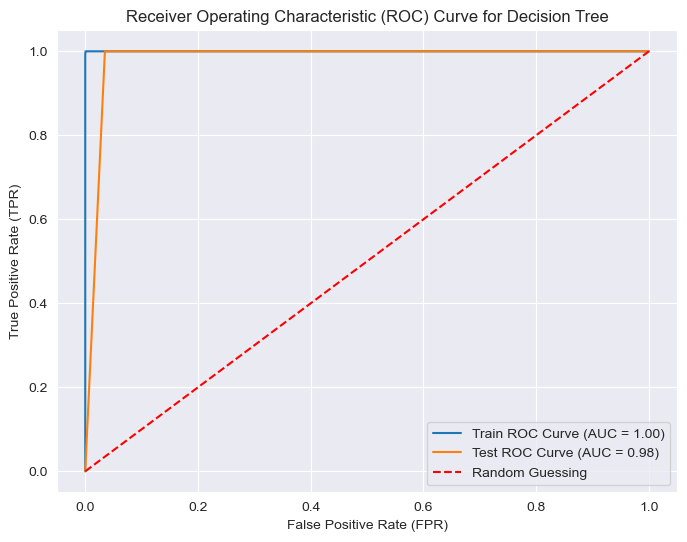

Train AUC: 1.0000
Test AUC: 0.9826


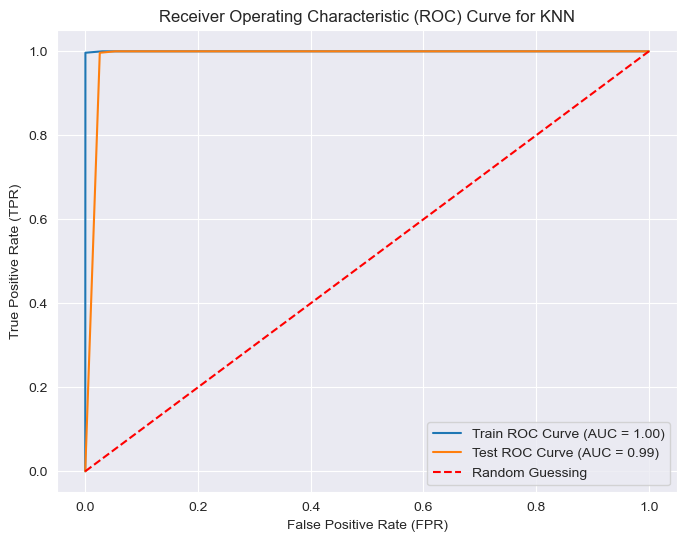

Train AUC: 0.9998
Test AUC: 0.9870


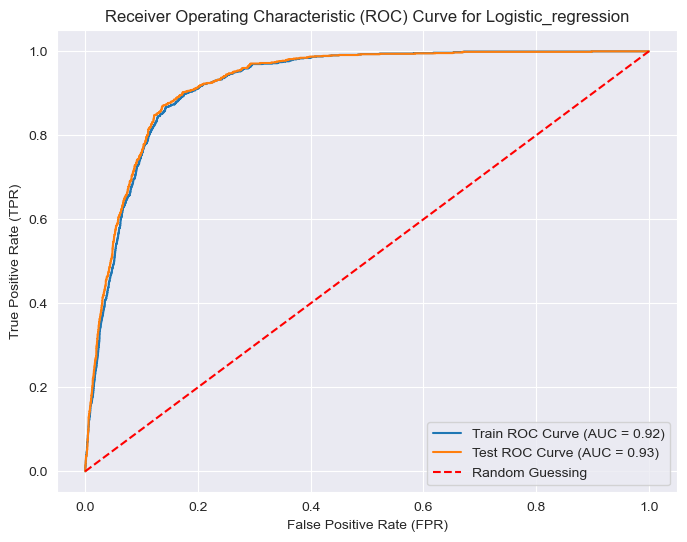

Train AUC: 0.9225
Test AUC: 0.9261


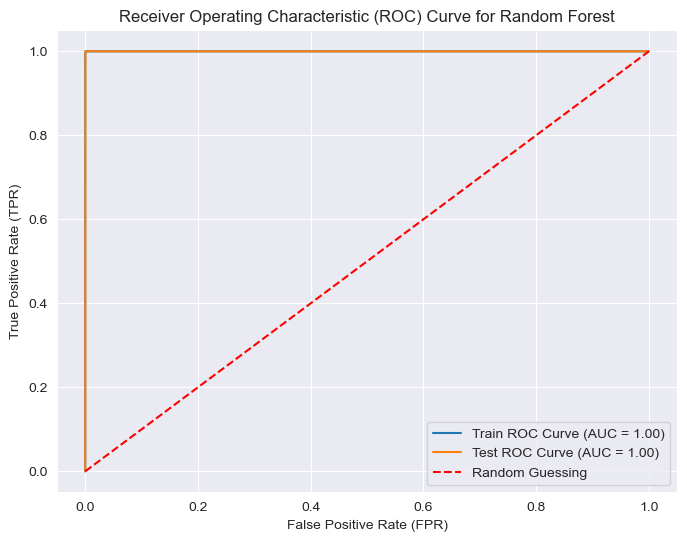

Train AUC: 1.0000
Test AUC: 0.9998


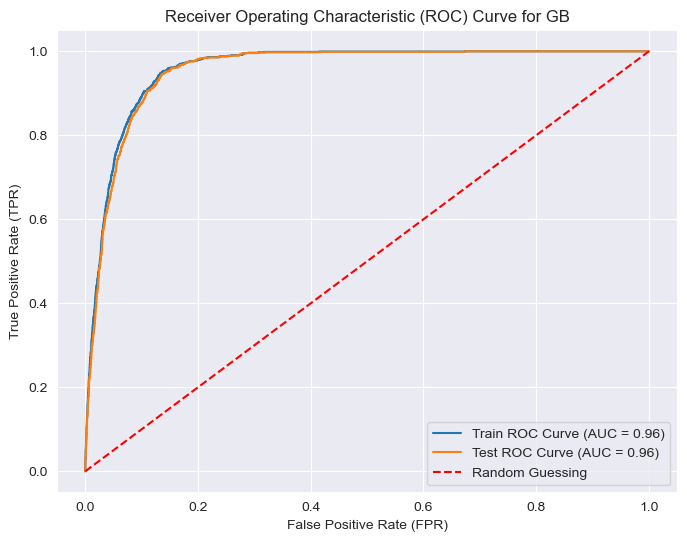

Train AUC: 0.9583
Test AUC: 0.9552


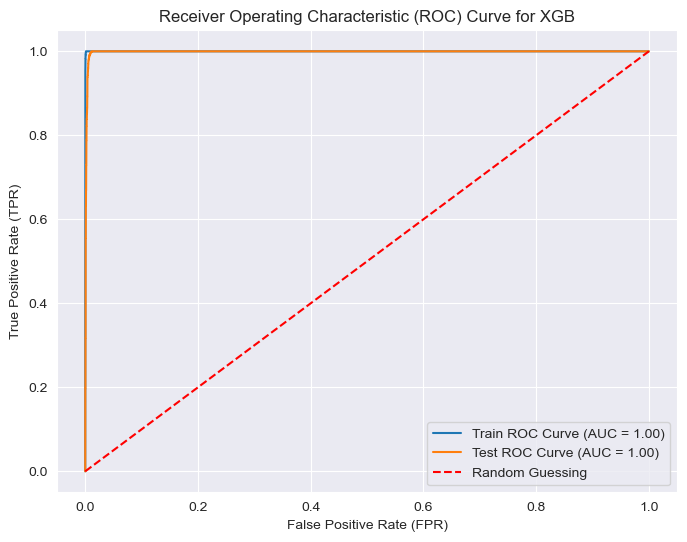

Train AUC: 1.0000
Test AUC: 0.9986


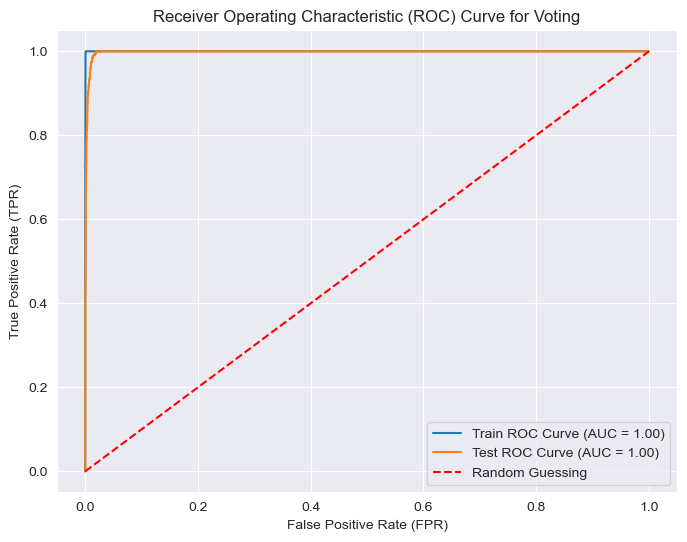

Train AUC: 0.9999
Test AUC: 0.9982


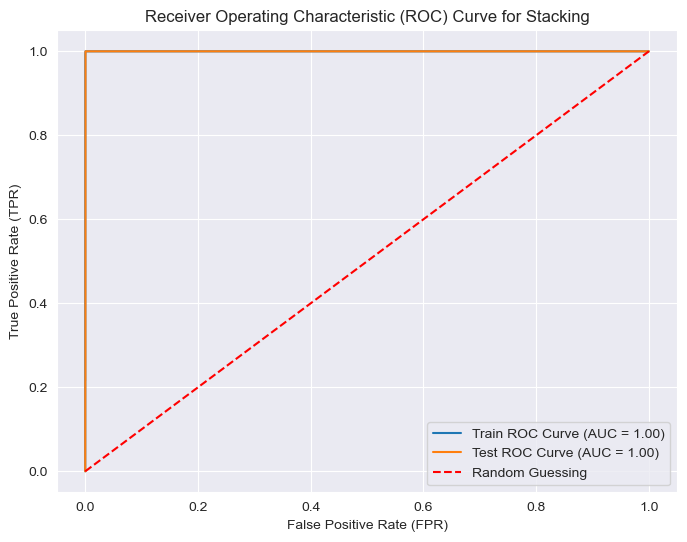

Train AUC: 1.0000
Test AUC: 0.9998


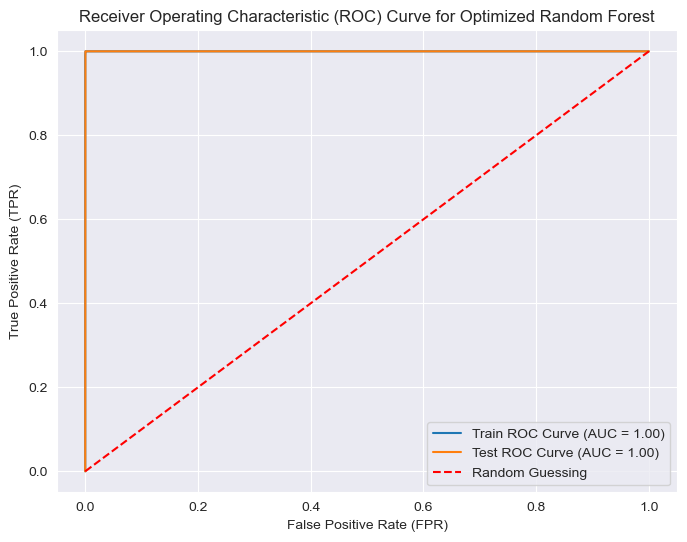

Train AUC: 1.0000
Test AUC: 0.9998


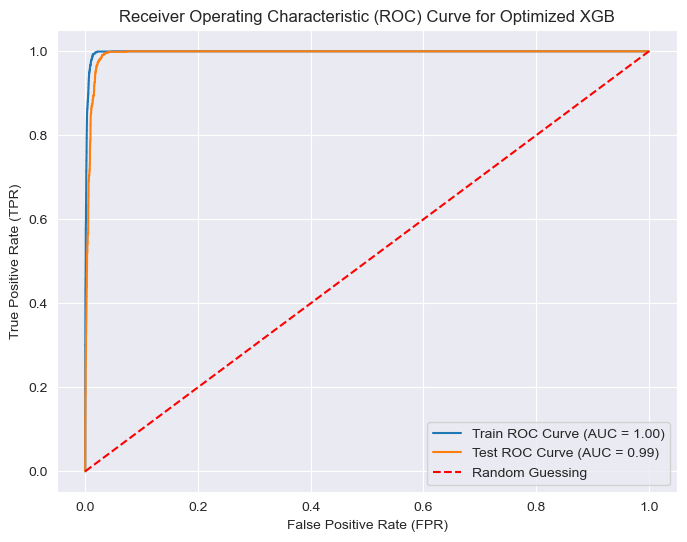

Train AUC: 0.9982
Test AUC: 0.9943


In [90]:
for model,model_name in zip(models,model_names):
    draw_AUC_graph(X_train,X_test,y_train,y_test,model,model_name)

## Visualizing the Confusion Matrix

DecisionTreeClassifier(), Decision Tree


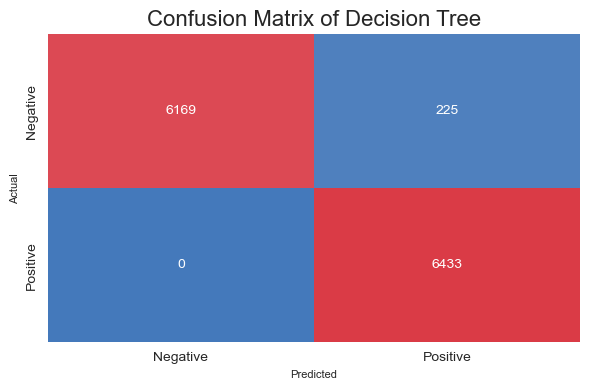

KNeighborsClassifier(), KNN


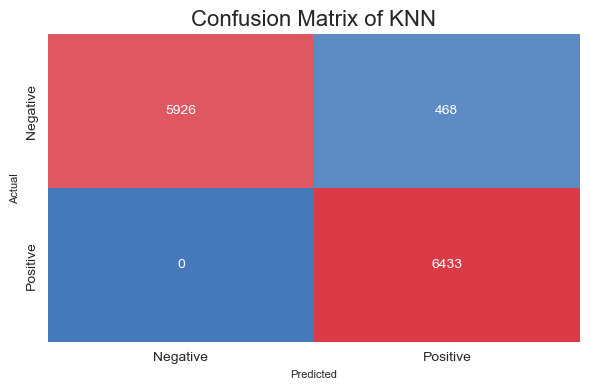

LogisticRegression(max_iter=1000), Logistic_regression


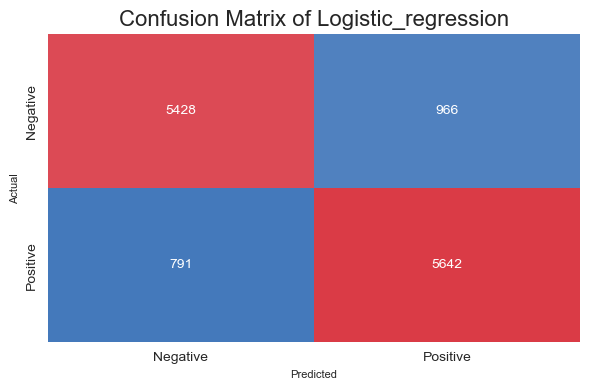

RandomForestClassifier(), Random Forest


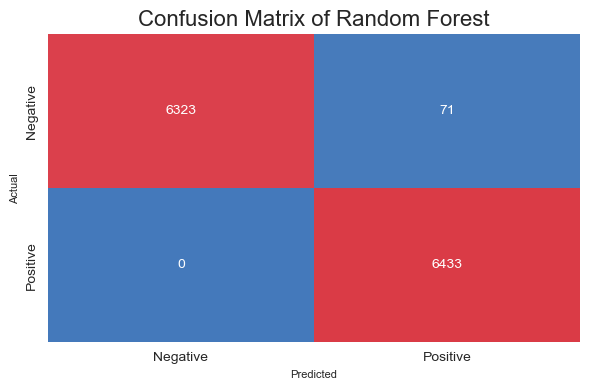

GradientBoostingClassifier(), GB


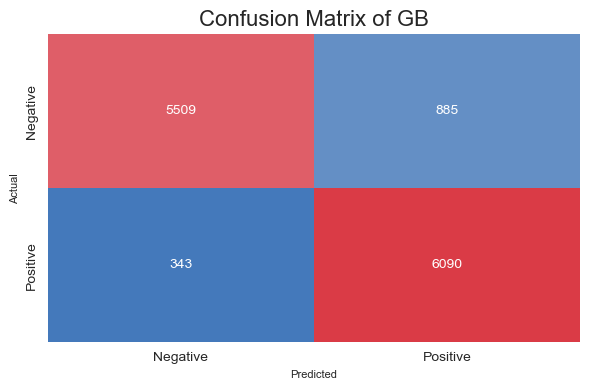

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...), XGB


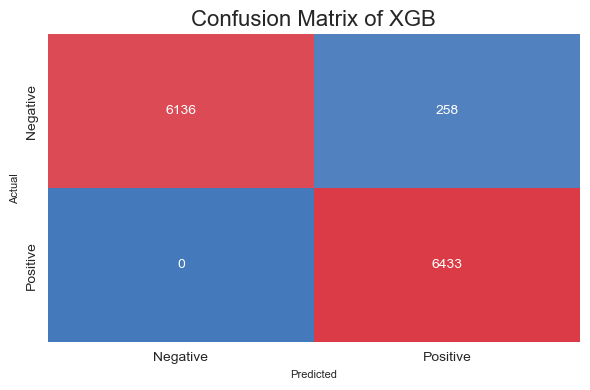

VotingClassifier(estimators=[('dtc', DecisionTreeClassifier()),
                             ('knn', KNeighborsClassifier()),
                             ('logistic', LogisticRegression(max_iter=1000)),
                             ('rfc', RandomForestClassifier()),
                             ('gb', GradientBoostingClassifier())],
                 voting='soft'), Voting


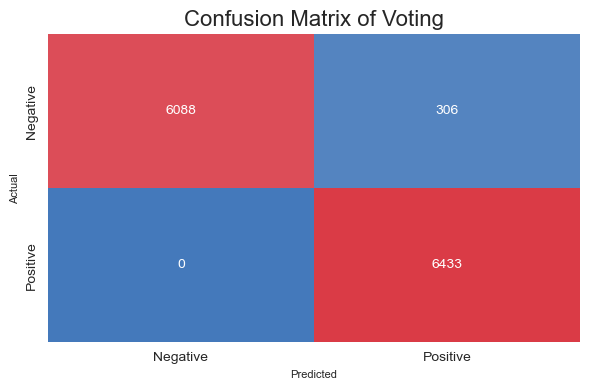

StackingClassifier(estimators=[('dtc', DecisionTreeClassifier()),
                               ('knn', KNeighborsClassifier()),
                               ('logistic', LogisticRegression(max_iter=1000)),
                               ('rfc', RandomForestClassifier()),
                               ('gb', GradientBoostingClassifier())]), Stacking


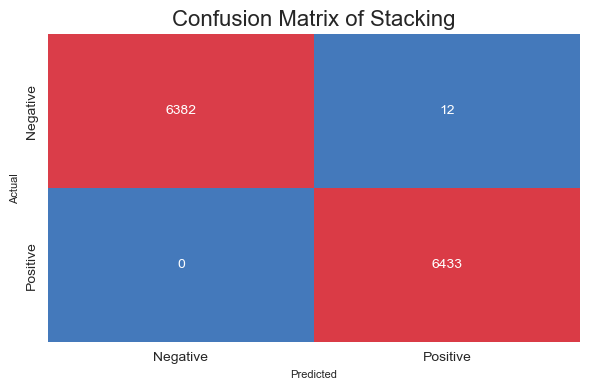

RandomForestClassifier(max_features=1, n_estimators=50, random_state=0), Optimized Random Forest


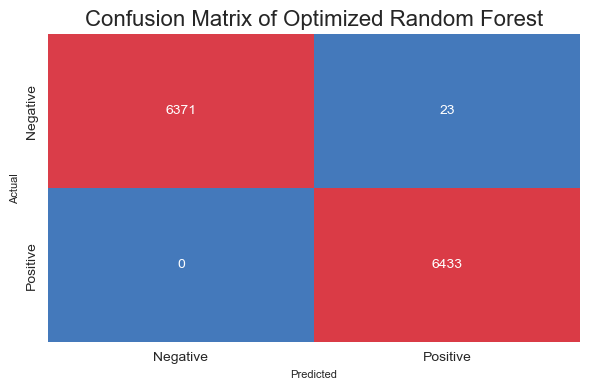

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_features=1,
              max_leaves=None, min_child_weight=None, min_samples_leaf=1,
              min_samples_split=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, ...), Optimized XGB


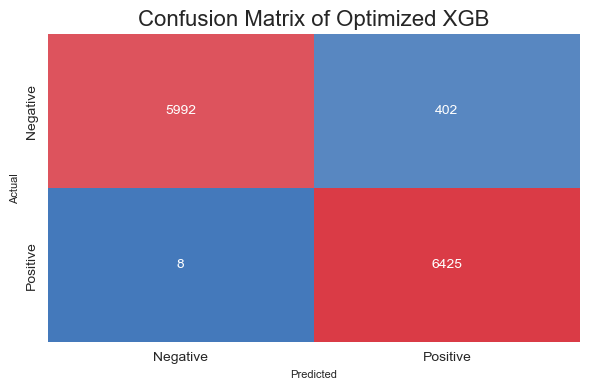

In [91]:
for model,model_name in zip(models,model_names):
    print(f"{model}, {model_name}")
    plot_confusion_matrix(X_test=X_test, y_test=y_test, model=model, model_name=model_name)

## Visualizing the bias,variance tradeoff and train,test,cross-validation scores

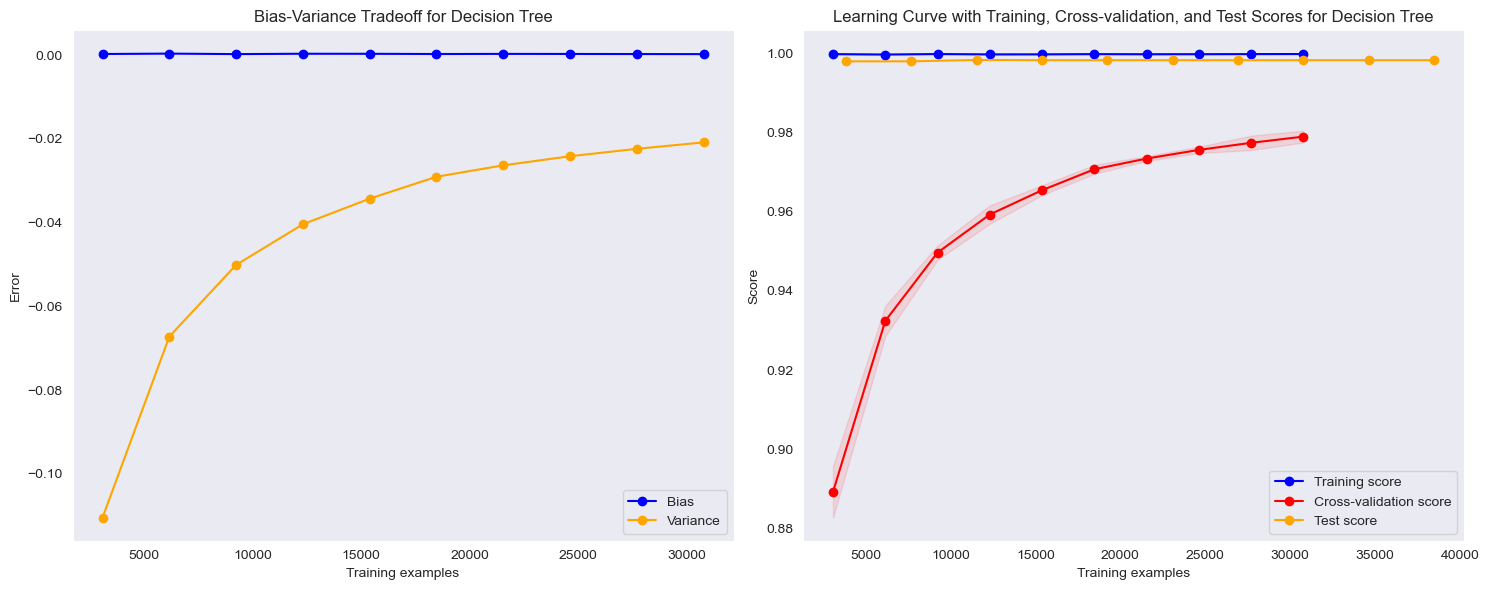

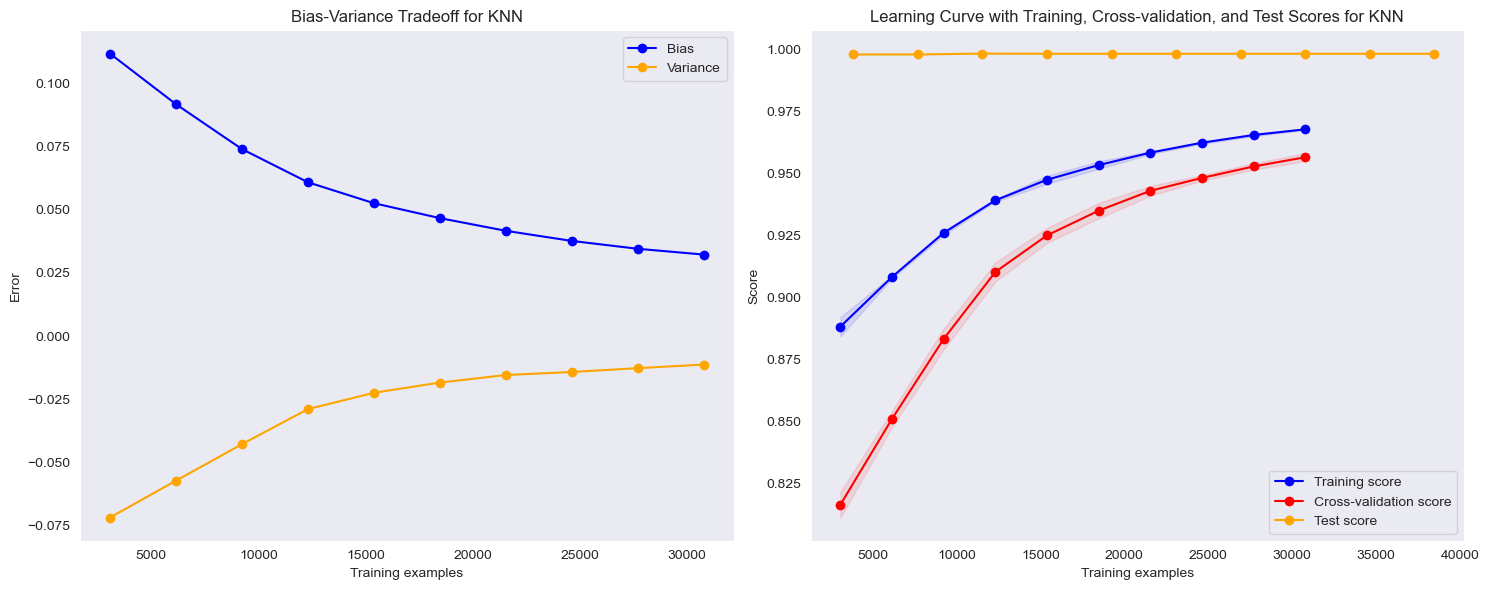

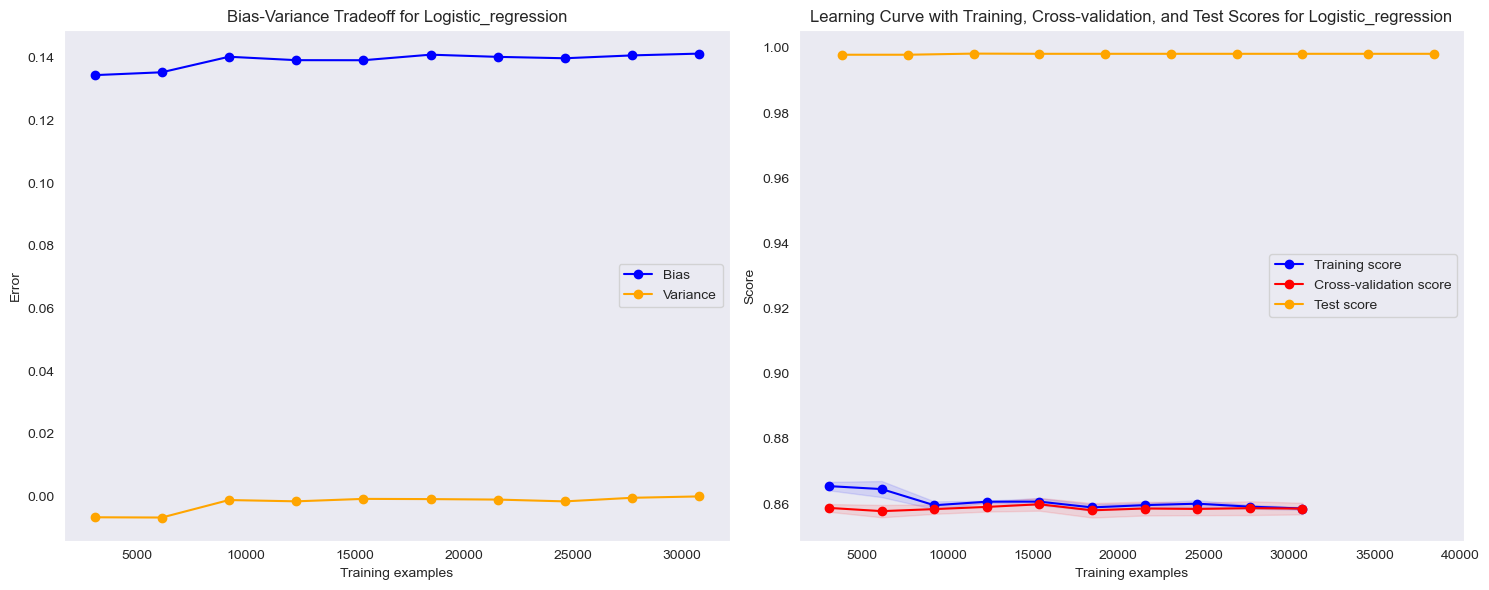

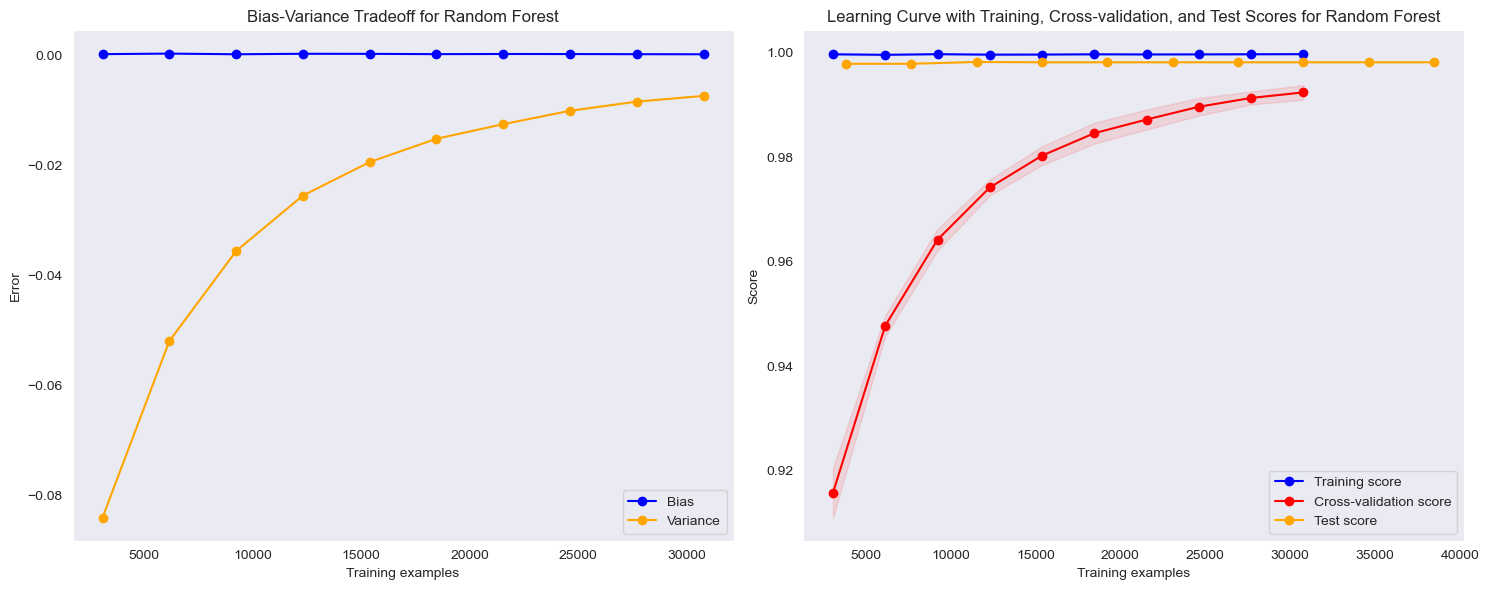

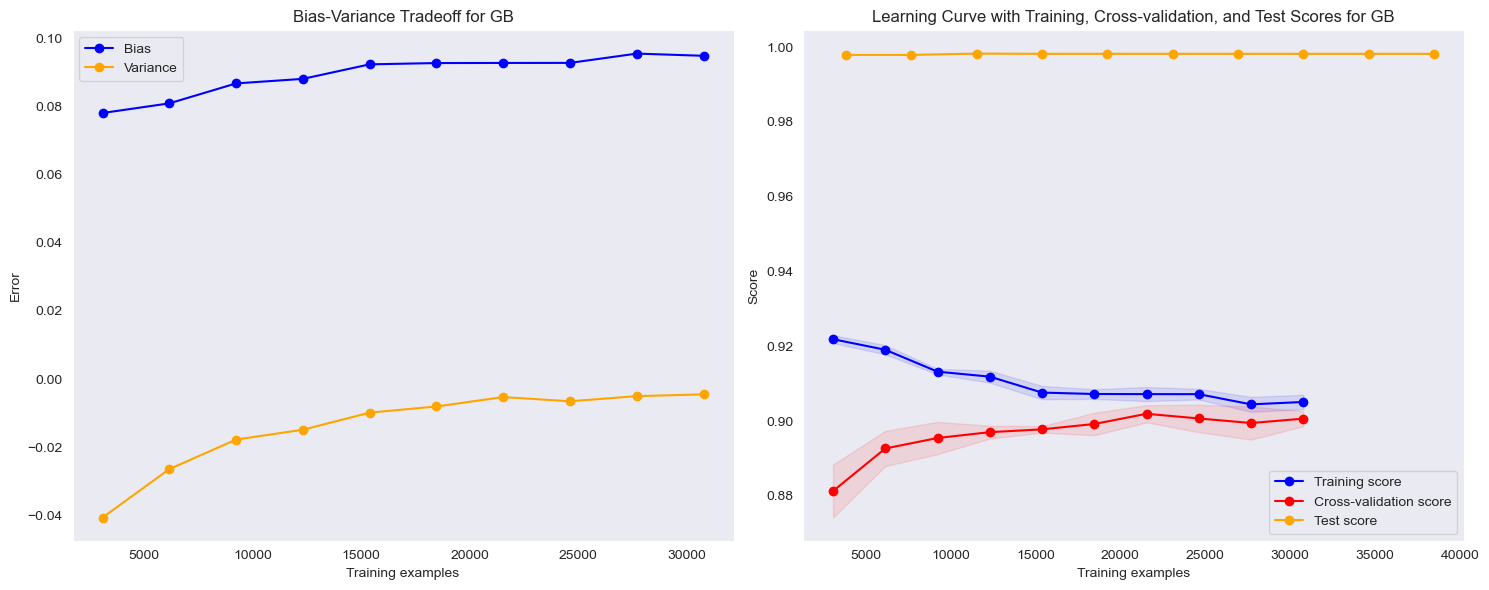

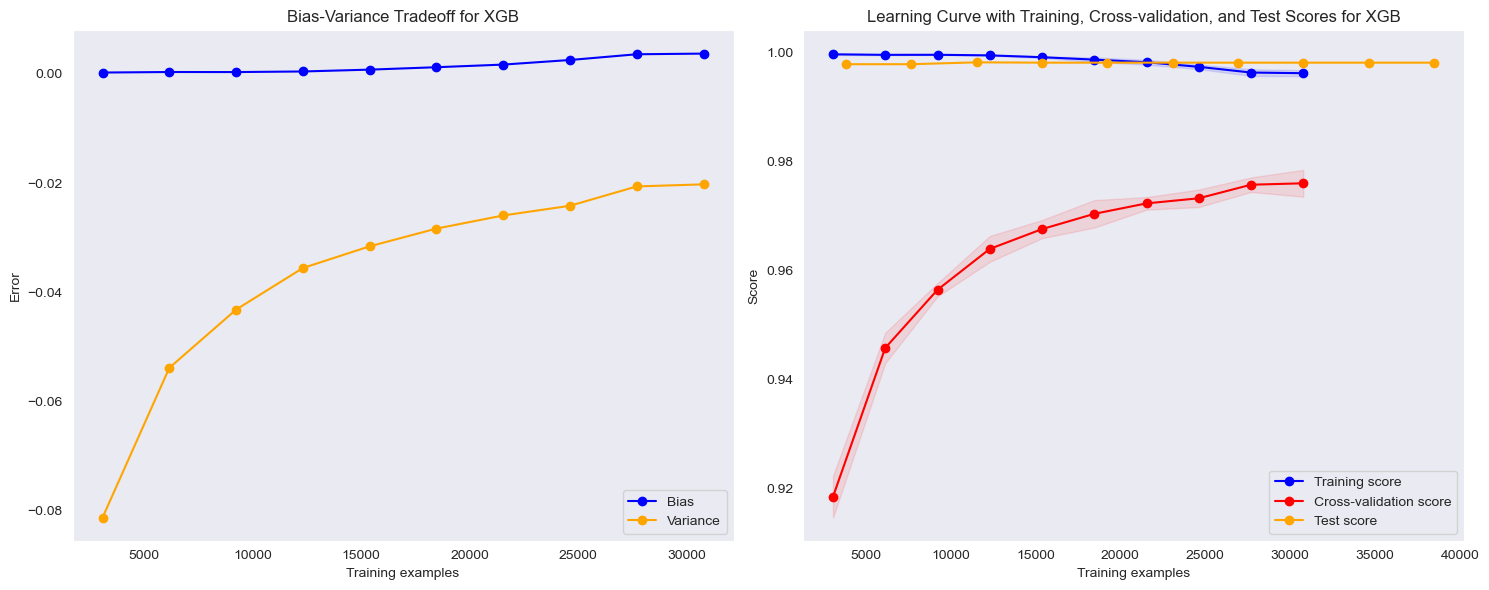

KeyboardInterrupt: 

In [92]:
for model, model_name in zip(models,model_names):
    visualize_fitting_scores(model=model ,model_name=model_name , X_train=X_train ,y_train=y_train)